In [1]:
### 
#from agents import Agent, Runner
from IPython.display import display, Markdown
import os
from openai import OpenAI
from bs4 import BeautifulSoup
client = OpenAI()

In [2]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference


In [3]:
import os
import time
import json
import re
import requests
import pandas as pd
from typing import TypedDict, List, Dict, Any
from bs4 import BeautifulSoup
from geofetch import Geofetcher
from openai import OpenAI
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableLambda

# ----------------------------------------
# Agent state schema
# ----------------------------------------

class AgentState(TypedDict):
    query_gene: str
    pathway_info: Dict[str, Any]
    metadata: Dict[str, Any]
    gse_list: list
    research_plan: str
    selected_gse: str  # ⬅️ now added
    selected_gses: List[str]  # ✅ new field for multiple GSEs
    deg_results: Dict[str, str]  # ✅ map GSE → output CSV path
# Utility to extract all GSE IDs from plan
def extract_all_gse_ids(plan_text: str) -> List[str]:
    return re.findall(r"GSE\d{5,}", plan_text)

def extract_gse_from_research_plan(state: AgentState) -> AgentState:
    plan = state.get("research_plan", "")
    match = re.search(r"GSE\d{5,}", plan)
    if match:
        selected_gse = match.group(0)
        print(f"🔍 Extracted GSE ID: {selected_gse}")
        return {**state, "selected_gse": selected_gse}
    else:
        print("⚠️ No GSE ID found in research plan.")
        return state

# LangGraph node: Extract GSEs from research plan and update state
def extract_gse_list_from_plan(state: AgentState) -> AgentState:
    plan = state.get("research_plan", "")
    gse_ids = extract_all_gse_ids(plan)
    print(f"🔍 Extracted GSE IDs: {gse_ids}")
    return {**state, "selected_gses": gse_ids}

# DEG analysis node: run DESeq2 for multiple studies
def run_deg_for_multiple_gses(state: AgentState) -> AgentState:
    gse_ids = state.get("selected_gses", [])
    if not gse_ids:
        raise ValueError("No selected GSEs found.")

    deg_paths = {}

    for gse_id in gse_ids:
        try:
            print(f"\n🧬 Running DESeq2 for: {gse_id}")
            count_path = f"rna_seq_analysis/{gse_id}_raw_counts.csv"
            if not os.path.exists(count_path):
                print(f"❌ Missing count file for {gse_id}")
                continue

            counts_df = pd.read_csv(count_path, index_col=0) + 1

            meta_df = pd.read_csv("geofetch_metadata/combined_metadata.csv")
            meta_gse = meta_df[meta_df["gse"] == gse_id].copy()

            meta_gse["condition"] = meta_gse["sample_title"].str.contains("PGE2", case=False).map({True: "treated", False: "control"})
            metadata_df = meta_gse.set_index("sample_geo_accession")[["condition"]]

            valid_samples = metadata_df.index.intersection(counts_df.columns)
            counts_df = counts_df[valid_samples]
            metadata_df = metadata_df.loc[valid_samples]

            if counts_df.empty or metadata_df.empty:
                print(f"⚠️ Skipping {gse_id}: no matching samples")
                continue

            inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(
                counts=counts_df.T,
                metadata=metadata_df,
                design_factors="condition",
                refit_cooks=True,
                inference=inference,
            )

            dds.deseq2()
            ds = DeseqStats(dds, contrast=["condition", "treated", "control"], inference=inference)
            ds.summary()

            output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
            ds.results_df.to_csv(output_csv, index=False)
            print(f"✅ Saved DEG results for {gse_id}: {output_csv}")
            deg_paths[gse_id] = output_csv

        except Exception as e:
            print(f"❌ Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}

def run_deg_for_multiple_gses_debug(state: AgentState) -> AgentState:
    gse_ids = state.get("selected_gses", [])
    if not gse_ids:
        print("⚠️ No selected GSEs found.")
        return state

    deg_paths = {}

    for gse_id in gse_ids:
        try:
            print(f"\n🧬 Running DESeq2 for: {gse_id}")
            count_path = f"rna_seq_analysis/{gse_id}_raw_counts.csv"
            if not os.path.exists(count_path):
                print(f"❌ Missing count file for {gse_id}")
                continue

            counts_df = pd.read_csv(count_path, index_col=0) + 1
            print(f"✅ Loaded count matrix: {counts_df.shape}")

            meta_df = pd.read_csv("geofetch_metadata/combined_metadata.csv")
            meta_gse = meta_df[meta_df["gse"] == gse_id].copy()
            print(f"✅ Loaded metadata: {meta_gse.shape}")

            meta_gse["condition"] = meta_gse["sample_title"].str.contains("PGE2", case=False).map({True: "treated", False: "control"})
            metadata_df = meta_gse.set_index("sample_geo_accession")[["condition"]]

            print(f"🔍 Metadata index (GSM): {list(metadata_df.index[:5])}")
            print(f"🔍 Count matrix columns (samples): {list(counts_df.columns[:5])}")

            valid_samples = metadata_df.index.intersection(counts_df.columns)
            print(f"🔗 Intersected samples: {list(valid_samples)}")

            counts_df = counts_df[valid_samples]
            metadata_df = metadata_df.loc[valid_samples]

            if counts_df.empty or metadata_df.empty:
                print(f"⚠️ Skipping {gse_id}: no matching samples")
                continue

            inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(
                counts=counts_df.T,
                metadata=metadata_df,
                design_factors="condition",
                refit_cooks=True,
                inference=inference,
            )

            dds.deseq2()
            ds = DeseqStats(dds, contrast=["condition", "treated", "control"], inference=inference)
            ds.summary()

            output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
            ds.results_df.to_csv(output_csv, index=False)
            print(f"✅ Saved DEG results for {gse_id}: {output_csv}")
            deg_paths[gse_id] = output_csv

        except Exception as e:
            print(f"❌ Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}


# ----------------------------------------
# Utility functions (LLM + GEO search)
# ----------------------------------------

client = OpenAI()

def extract_json_block(text):
    match = re.search(r"```json\s*(\{.*?\})\s*```", text, re.DOTALL)
    if match:
        return json.loads(match.group(1))
    else:
        return json.loads(text)


def extract_json_block(text: str) -> dict:
    """
    Extract and parse the first JSON block from LLM output, with fallback and error reporting.
    """
    import json
    import re

    try:
        match = re.search(r"```json\s*({.*?})\s*```", text, re.DOTALL)
        if match:
            return json.loads(match.group(1))
        return json.loads(text)  # fallback if no block match
    except json.JSONDecodeError as e:
        print("⚠️ JSON decode error:", e)
        print("🔍 Raw content:\n", text[:1000])  # preview
        raise




def generate_pathway_info(query_gene, model="gpt-4o-mini", temperature=0.3):
    prompt = f"""
You are a biomedical assistant.

Given the gene {query_gene}, return:
1. Key gene symbols in the same biological pathway.
2. Drugs or compounds that inhibit this pathway or {query_gene}'s activity.
3. The disease areas or biological processes this pathway is involved in.

Provide answers in JSON format with keys: "genes", "drugs", "pathways"
    """
    completion = client.chat.completions.create(
        model=model,
        temperature=temperature,
        messages=[{"role": "user", "content": prompt}]
    )
    content = completion.choices[0].message.content
    return extract_json_block(content)



def scrape_organism_from_geo_html(geo_accession):
    url = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={geo_accession}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        organism_row = soup.find("td", string="Organism")
        if organism_row and organism_row.find_next_sibling("td"):
            return organism_row.find_next_sibling("td").text.strip()
    except Exception as e:
        print(f"⚠️ Failed to scrape organism for {geo_accession}: {e}")
    return "Unknown"

def search_geo_datasets(keyword, retmax=10):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "gds",
        "term": keyword,
        "retmode": "json",
        "retmax": retmax
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.json().get("esearchresult", {}).get("idlist", [])

def fetch_gse_accessions(id_list):
    if not id_list:
        return {}
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
    params = {
        "db": "gds",
        "id": ",".join(id_list),
        "retmode": "json"
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    summaries = response.json().get("result", {})
    summaries.pop("uids", None)
    gse_dict = {}
    for uid, info in summaries.items():
        accession = info.get("accession")
        title = info.get("title")
        link = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={accession}"
        organism = scrape_organism_from_geo_html(accession)
        gse_dict[accession] = {
            "title": title,
            "organism": organism,
            "link": link
        }
    return gse_dict

def search_geo_items(item_list, label="gene", max_results=5):
    results = {}
    for item in item_list:
        query = f"{item} AND rna-seq"
        print(f"🔍 Searching GEO for {label}: {item}")
        ids = search_geo_datasets(query, retmax=max_results)
        datasets = fetch_gse_accessions(ids)
        results[item] = datasets
        time.sleep(0.3)
    return results

def get_geofetch_projects(gse_list, metadata_folder="geofetch_metadata"):
    geof = Geofetcher(
        processed=True,
        acc_anno=True,
        discard_soft=True,
        metadata_folder=metadata_folder
    )
    projects = {}
    for gse in gse_list:
        try:
            print(f"📥 Fetching metadata for {gse}")
            result = geof.get_projects(gse)
            projects.update(result)
        except Exception as e:
            print(f"❌ Failed to fetch {gse}: {e}")
    return projects

import subprocess
def download_processed_files_via_cli(gse_list, output_dir="geofetch_metadata", overwrite=False):
    for gse in gse_list:
        gse_path = os.path.join(output_dir, gse)
        if os.path.exists(gse_path) and not overwrite:
            print(f"✅ {gse}: already exists at {gse_path}, skipping.")
            continue
        try:
            subprocess.run(
                ["geofetch", "-i", gse, "--processed", "-m", output_dir],
                check=True
            )
            print(f"✅ Finished downloading for {gse}")
        except subprocess.CalledProcessError as e:
            print(f"❌ geofetch failed for {gse}: {e}")

def save_combined_metadata_csv_from_state(state: Dict, csv_path: str = "geofetch_metadata/combined_metadata.csv") -> pd.DataFrame:
    metadata = state.get("metadata", {})
    if not metadata:
        raise ValueError("No metadata found in the agent state.")

    all_dfs = []
    for gse, project in metadata.items():
        try:
            df = project.sample_table.copy()
            df["source_gse"] = gse
            all_dfs.append(df)
        except Exception as e:
            print(f"⚠️ Failed to extract sample_table from {gse}: {e}")

    if not all_dfs:
        raise ValueError("No sample tables to save.")

    combined_df = pd.concat(all_dfs, ignore_index=True)
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    combined_df.to_csv(csv_path, index=False)
    print(f"✅ Combined metadata saved to: {os.path.abspath(csv_path)}")
    return combined_df

# ----------------------------------------
# Agent 1: Ingestor node
# ----------------------------------------

def ingest_and_prepare(state: dict) -> dict:
    query_gene = state["query_gene"]
    pathway_info = generate_pathway_info(query_gene)
    gene_list = pathway_info.get("genes", [])
    drug_list = pathway_info.get("drugs", [])

    gene_results = search_geo_items(gene_list, label="gene")
    drug_results = search_geo_items(drug_list, label="drug")

    all_gse = set()
    for r in [gene_results, drug_results]:
        for v in r.values():
            all_gse.update(v.keys())
    all_gse = list(all_gse)

    metadata = get_geofetch_projects(all_gse, metadata_folder="geofetch_metadata")
    download_processed_files_via_cli(all_gse, output_dir="geofetch_metadata")

    try:
        save_combined_metadata_csv_from_state({"metadata": metadata})
    except Exception as e:
        print(f"⚠️ Failed to save metadata CSV: {e}")

    return {
        "query_gene": query_gene,
        "pathway_info": pathway_info,
        "metadata": metadata,
        "gse_list": all_gse
    }



import subprocess
import tarfile
import gzip
import shutil
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, parse_qs, unquote
from pathlib import Path

# ----------------------------------------
# Utility: Scrape GEO supplementary HTTP links
# ----------------------------------------
def scrape_geo_supplementary_downloads(gse_id: str):
    base_url = "https://www.ncbi.nlm.nih.gov"
    url = f"{base_url}/geo/query/acc.cgi?acc={gse_id}"

    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        tables = soup.find_all("table")

        for table in tables:
            if "Supplementary file" in table.get_text():
                rows = table.find_all("tr")
                downloadable_files = []

                for row in rows[1:]:
                    cols = row.find_all("td")
                    if len(cols) >= 3:
                        file_name = cols[0].text.strip()
                        download_cell = cols[2]
                        links = download_cell.find_all("a", href=True)

                        for a_tag in links:
                            href = a_tag["href"]
                            if href.startswith("/geo/download"):
                                full_http_link = urljoin(base_url, href)
                                downloadable_files.append((file_name, full_http_link))
                                break
                return downloadable_files
        return []
    except Exception as e:
        print(f"❌ Failed to scrape {gse_id}: {e}")
        return []

# ----------------------------------------
# Embedded in Ingestor Agent
# ----------------------------------------
def ingest_and_prepare(state: dict) -> dict:
    query_gene = state["query_gene"]
    pathway_info = generate_pathway_info(query_gene)
    gene_list = pathway_info.get("genes", [])
    drug_list = pathway_info.get("drugs", [])

    gene_results = search_geo_items(gene_list, label="gene")
    drug_results = search_geo_items(drug_list, label="drug")

    all_gse = set()
    for r in [gene_results, drug_results]:
        for v in r.values():
            all_gse.update(v.keys())
    all_gse = list(all_gse)

    # ----------------------------------------
    # Download each GSE using embedded logic
    # ----------------------------------------
    base_dir = Path("rna_seq_analysis")
    for gse_id in all_gse:
        download_dir = base_dir / gse_id

        if download_dir.exists() and any(download_dir.iterdir()):
            print(f"📁 Skipping {gse_id}: folder already exists.")
            continue

        download_dir.mkdir(parents=True, exist_ok=True)
        files = scrape_geo_supplementary_downloads(gse_id)
        if not files:
            print(f"⚠️ No supplementary files found for {gse_id}")
            continue

        file_name, url = files[0]
        if not file_name:
            parsed = urlparse(url)
            qs = parse_qs(parsed.query)
            file_name = unquote(qs.get("file", ["unnamed_file"])[0])

        file_path = download_dir / file_name
        print(f"📥 Downloading {file_name} → {file_path.as_posix()}")

        try:
            subprocess.run(["curl", "-L", "-o", file_path.as_posix(), url], check=True)
        except subprocess.CalledProcessError as e:
            print(f"❌ Download failed for {gse_id}: {e}")
            continue

        try:
            if tarfile.is_tarfile(file_path):
                print("🗂️ Extracting TAR...")
                with tarfile.open(file_path, "r:*") as tar:
                    tar.extractall(path=download_dir)
            elif file_path.suffix == ".gz" and not file_path.name.endswith(".tar.gz"):
                unzipped_path = file_path.with_suffix("")
                print("🗂️ Extracting GZ...")
                with gzip.open(file_path, 'rb') as f_in:
                    with open(unzipped_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
        except Exception as e:
            print(f"⚠️ Extraction failed for {gse_id}: {e}")
            continue

    # ----------------------------------------
    # Continue with metadata and return
    # ----------------------------------------
    metadata = get_geofetch_projects(all_gse, metadata_folder="geofetch_metadata")
    download_processed_files_via_cli(all_gse, output_dir="geofetch_metadata")

    try:
        save_combined_metadata_csv_from_state({"metadata": metadata})
    except Exception as e:
        print(f"⚠️ Failed to save metadata CSV: {e}")

    return {
        "query_gene": query_gene,
        "pathway_info": pathway_info,
        "metadata": metadata,
        "gse_list": all_gse
    }

# ----------------------------------------
# Agent 2: Analyst node
# ----------------------------------------

def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    metadata = state["metadata"]
    drug_list = state["pathway_info"].get("drugs", [])
    query_gene = state["query_gene"]
    selected = []

    for gse, project in metadata.items():
        df = project.sample_table
        if "processed_file_ftp" in df.columns and df["processed_file_ftp"].notna().any():
            if any(drug.lower() in df.to_string().lower() for drug in drug_list):
                selected.append((gse, df.shape[0]))

    plan = f"🧬 Research Plan for {query_gene} and drugs {drug_list}:\n"
    if not selected:
        plan += "No relevant processed datasets were found.\n"
    else:
        plan += f"{len(selected)} datasets selected:\n"
        for gse, n in selected:
            plan += f"  - {gse} ({n} samples)\n"
        plan += "\nNext: perform differential expression and gene signature clustering."

    return {**state, "research_plan": plan}


def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    import pandas as pd
    import os

    csv_path = "geofetch_metadata/combined_metadata.csv"
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ Metadata CSV not found at {csv_path}")

    df = pd.read_csv(csv_path)

    # Ensure required columns exist
    required_columns = {"sample_name", "sample_source_name_ch1", "sample_title"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"❌ Metadata CSV must include columns: {required_columns}")

    # Take first 50 rows for LLM context
    selected_df = df[list(required_columns)].fillna("").head(50)
    table_preview = selected_df.to_markdown(index=False)

    query_gene = state["query_gene"]
    drug_list = state["pathway_info"].get("drugs", [])
    selected_df = df[["sample_name", "sample_source_name_ch1", "sample_title"]].fillna("").head(50)
    table_preview = selected_df.to_markdown(index=False)
    print("🧪 Table preview sent to LLM:\n", table_preview)  # ✅ Add this line

    # Build LLM prompt
    prompt = f"""
You are a biomedical research assistant.

The target gene is **{query_gene}**, and the related drugs of interest are: {', '.join(drug_list)}.

Below is a preview of sample metadata (first 50 rows) from multiple GEO studies. Each row includes:
- sample name
- sample source (cell line, tissue)
- sample title (may indicate treatment or condition)

Your task:
1. Identify which studies include drug-treated samples.
2. Identify the control groups if available.
3. Determine the sample types (e.g., cell lines or tissues).
4. Recommend studies and sample comparisons suitable for differential gene expression and drug-response signature analysis.

Respond with:
- GSE or study names (if known)
- The experimental comparison design
- Why the dataset is suitable (or not)
- Bullet points summarizing each recommended comparison

Sample Metadata Table:

"""

    # Call LLM
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    research_plan = response.choices[0].message.content.strip()

    return {
        **state,
        "research_plan": research_plan
    }

###
def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    import pandas as pd
    import os

    csv_path = "geofetch_metadata/combined_metadata.csv"
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ Metadata CSV not found at {csv_path}")

    df = pd.read_csv(csv_path)

    # Ensure required columns are available
    required_cols = ["gse", "sample_name", "sample_title", "sample_source_name_ch1", "sample_geo_accession"]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"❌ Metadata CSV must contain the following columns: {required_cols}")

    # Clean and preview first 30 rows
    preview_df = df[required_cols].fillna("").head(30)
    preview_text = preview_df.to_string(index=False)

    query_gene = state["query_gene"]
    drug_list = state["pathway_info"].get("drugs", [])

    prompt = f"""
You are a biomedical research assistant.

The target gene is **{query_gene}** and the related drugs of interest are: {', '.join(drug_list)}.

Below is a preview of sample metadata from several GEO datasets.
Each row includes:
- GSE accession
- Sample name
- Sample title (may contain treatment or control info)
- Sample source (cell type or tissue)
- Sample GEO accession

Sample Metadata Table:
{preview_text}

Based on the sample names, titles, and sources:
1. Which GSE studies contain drug-treated samples and matching control groups?
2. What cell types or tissues are used?
3. Which treatments are applied? What are the controls?
4. Recommend GSEs and sample pairs suitable for differential gene expression to identify drug-response gene signatures.

Be specific, refer to GSE and sample names where possible, and explain why you recommend them.
"""

    # Call OpenAI LLM
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    research_plan = response.choices[0].message.content.strip()

    return {
        **state,
        "research_plan": research_plan
    }

# ----------------------------------------
# LangGraph pipeline
# ----------------------------------------

#workflow = StateGraph(state_schema=AgentState)
#workflow.add_node("Ingestor", RunnableLambda(ingest_and_prepare))
#workflow.add_node("Analyst", RunnableLambda(analyze_metadata_and_plan))
#workflow.add_node("GSESelector", RunnableLambda(extract_gse_from_research_plan))
#workflow.set_entry_point("Ingestor")
#workflow.add_edge("Ingestor", "Analyst")
#workflow.set_finish_point("Analyst")
#workflow.add_edge("Analyst", "GSESelector")
# Set finish point to "GSESelector" if no DEGRunner yet
#workflow.set_finish_point("GSESelector")
#graph = workflow.compile()

#############
# Build the pipeline
workflow = StateGraph(state_schema=AgentState)

# Add nodes
workflow.add_node("Ingestor", RunnableLambda(ingest_and_prepare))
workflow.add_node("Analyst", RunnableLambda(analyze_metadata_and_plan))
workflow.add_node("GSEListExtractor", RunnableLambda(extract_gse_list_from_plan))
#workflow.add_node("DEGRunner", RunnableLambda(run_deg_for_multiple_gses))
workflow.add_node("DEGRunner", RunnableLambda(run_deg_for_multiple_gses_debug))
# Connect nodes
workflow.set_entry_point("Ingestor")
workflow.add_edge("Ingestor", "Analyst")
workflow.add_edge("Analyst", "GSEListExtractor")
workflow.add_edge("GSEListExtractor", "DEGRunner")

# Final output node
workflow.set_finish_point("DEGRunner")

# Compile the graph
graph = workflow.compile()


# ----------------------------------------
# Invoke the graph
# ----------------------------------------



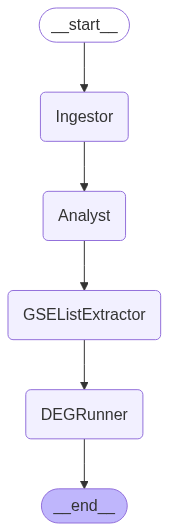

In [4]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [5]:
if __name__ == "__main__":
    result = graph.invoke({"query_gene": "COX2"})
    print("\n📋 Final Research Plan:")
    print(result["research_plan"])
    print(result.get("research_plan", ""))
    print("\n📂 DEG Results:")
    results = result.get("deg_results", {})
    if isinstance(results, dict):
        for gse, path in results.items():
            print(f" - {gse}: {path}")
    else:
        print("❌ DEG results not found or not formatted correctly.")

🔍 Searching GEO for gene: PTGS1
🔍 Searching GEO for gene: PTGES
🔍 Searching GEO for gene: PTGS2
🔍 Searching GEO for gene: CYP2C9
🔍 Searching GEO for gene: CYP2C19
🔍 Searching GEO for gene: CYP3A4
🔍 Searching GEO for gene: IL1B
🔍 Searching GEO for gene: TNF
🔍 Searching GEO for drug: Aspirin
🔍 Searching GEO for drug: Ibuprofen
🔍 Searching GEO for drug: Naproxen
🔍 Searching GEO for drug: Celecoxib
🔍 Searching GEO for drug: Diclofenac
🔍 Searching GEO for drug: Indomethacin
🔍 Searching GEO for drug: Meloxicam
📁 Skipping GSE242272: folder already exists.
📥 Downloading GSE242369_raw_counts.txt.gz → rna_seq_analysis/GSE242369/GSE242369_raw_counts.txt.gz
🗂️ Extracting GZ...
📁 Skipping GSE95802: folder already exists.
📥 Downloading unnamed_file → rna_seq_analysis/GSE279800/unnamed_file
🗂️ Extracting TAR...
📥 Downloading GSE97066_master_list_of_gene_counts_MIN.aorta_gavage_cele_rofe_vehicle.txt.gz → rna_seq_analysis/GSE97066/GSE97066_master_list_of_gene_counts_MIN.aorta_gavage_cele_rofe_vehicle.t

[INFO] [02:26:28] Metadata folder: C:\Users\difen\POPPER\geofetch_metadata\project_name
[INFO] [02:26:28] Trying GSE242272 (not a file) as accession...
[INFO] [02:26:28] Processing accession 1 of 1: 'GSE242272'
[INFO] [02:26:28] Trying GSE242272 (not a file) as accession...
[INFO] [02:26:28] Skipped 0 accessions. Starting now.
[INFO] [02:26:28] Processing accession 1 of 1: 'GSE242272'


🗂️ Extracting GZ...
📥 Fetching metadata for GSE242272


[INFO] [02:26:29] 
Total number of processed SAMPLES files found is: 18
[INFO] [02:26:29] Total number of processed SERIES files found is: 0
[INFO] [02:26:29] Expanding metadata list...
[INFO] [02:26:29] Expanding metadata list...
[INFO] [02:26:29] Finished processing 1 accession(s)
[INFO] [02:26:29] Cleaning soft files ...
[INFO] [02:26:29] Unifying and saving of metadata... 
[INFO] [02:26:30] Trying GSE242369 (not a file) as accession...
[INFO] [02:26:30] Trying GSE242369 (not a file) as accession...
[INFO] [02:26:30] Skipped 0 accessions. Starting now.
[INFO] [02:26:30] Processing accession 1 of 1: 'GSE242369'


📥 Fetching metadata for GSE242369


[INFO] [02:26:31] Total number of processed SERIES files found is: 1
[INFO] [02:26:31] Expanding metadata list...
[INFO] [02:26:31] Expanding metadata list...
[INFO] [02:26:31] Finished processing 1 accession(s)
[INFO] [02:26:31] Cleaning soft files ...
[INFO] [02:26:31] No files found. No data to save. File geofetch_metadata\project_name\GSE242369_samples\GSE242369_samples.csv won't be created
[INFO] [02:26:31] Trying GSE95802 (not a file) as accession...
[INFO] [02:26:31] Trying GSE95802 (not a file) as accession...
[INFO] [02:26:31] Skipped 0 accessions. Starting now.
[INFO] [02:26:31] Processing accession 1 of 1: 'GSE95802'


📥 Fetching metadata for GSE95802


[INFO] [02:26:33] Total number of processed SERIES files found is: 1
[INFO] [02:26:33] Expanding metadata list...
[INFO] [02:26:33] Expanding metadata list...
[INFO] [02:26:33] Finished processing 1 accession(s)
[INFO] [02:26:33] Cleaning soft files ...
[INFO] [02:26:33] No files found. No data to save. File geofetch_metadata\project_name\GSE95802_samples\GSE95802_samples.csv won't be created
[INFO] [02:26:33] Trying GSE279800 (not a file) as accession...
[INFO] [02:26:33] Trying GSE279800 (not a file) as accession...
[INFO] [02:26:33] Skipped 0 accessions. Starting now.
[INFO] [02:26:33] Processing accession 1 of 1: 'GSE279800'


📥 Fetching metadata for GSE279800


[INFO] [02:26:35] 
Total number of processed SAMPLES files found is: 8
[INFO] [02:26:35] Total number of processed SERIES files found is: 0
[INFO] [02:26:35] Expanding metadata list...
[INFO] [02:26:35] Expanding metadata list...
[INFO] [02:26:35] Finished processing 1 accession(s)
[INFO] [02:26:35] Cleaning soft files ...
[INFO] [02:26:35] Unifying and saving of metadata... 
[INFO] [02:26:35] Trying GSE97066 (not a file) as accession...
[INFO] [02:26:35] Trying GSE97066 (not a file) as accession...
[INFO] [02:26:35] Skipped 0 accessions. Starting now.
[INFO] [02:26:35] Processing accession 1 of 1: 'GSE97066'


📥 Fetching metadata for GSE97066


[INFO] [02:26:37] Total number of processed SERIES files found is: 1
[INFO] [02:26:37] Expanding metadata list...
[INFO] [02:26:37] Expanding metadata list...
[INFO] [02:26:37] Finished processing 1 accession(s)
[INFO] [02:26:37] Cleaning soft files ...
[INFO] [02:26:37] No files found. No data to save. File geofetch_metadata\project_name\GSE97066_samples\GSE97066_samples.csv won't be created
[INFO] [02:26:37] Trying GSE222593 (not a file) as accession...
[INFO] [02:26:37] Trying GSE222593 (not a file) as accession...
[INFO] [02:26:37] Skipped 0 accessions. Starting now.
[INFO] [02:26:37] Processing accession 1 of 1: 'GSE222593'


📥 Fetching metadata for GSE222593


[INFO] [02:26:56] 
Total number of processed SAMPLES files found is: 355
[INFO] [02:26:56] Total number of processed SERIES files found is: 6
[INFO] [02:26:56] Expanding metadata list...
[INFO] [02:26:56] Expanding metadata list...
[INFO] [02:26:56] Finished processing 1 accession(s)
[INFO] [02:26:56] Cleaning soft files ...
[INFO] [02:26:56] Unifying and saving of metadata... 
[INFO] [02:26:56] Trying GSE286021 (not a file) as accession...
[INFO] [02:26:56] Trying GSE286021 (not a file) as accession...
[INFO] [02:26:56] Skipped 0 accessions. Starting now.
[INFO] [02:26:56] Processing accession 1 of 1: 'GSE286021'


📥 Fetching metadata for GSE286021


[INFO] [02:26:58] Total number of processed SERIES files found is: 1
[INFO] [02:26:58] Expanding metadata list...
[INFO] [02:26:58] Expanding metadata list...
[INFO] [02:26:58] Finished processing 1 accession(s)
[INFO] [02:26:58] Cleaning soft files ...
[INFO] [02:26:58] No files found. No data to save. File geofetch_metadata\project_name\GSE286021_samples\GSE286021_samples.csv won't be created
[INFO] [02:26:58] Trying GSE175744 (not a file) as accession...
[INFO] [02:26:58] Trying GSE175744 (not a file) as accession...
[INFO] [02:26:58] Skipped 0 accessions. Starting now.
[INFO] [02:26:58] Processing accession 1 of 1: 'GSE175744'


📥 Fetching metadata for GSE175744


[INFO] [02:27:01] Total number of processed SERIES files found is: 1
[INFO] [02:27:01] Expanding metadata list...
[INFO] [02:27:01] Expanding metadata list...
[INFO] [02:27:01] Finished processing 1 accession(s)
[INFO] [02:27:01] Cleaning soft files ...
[INFO] [02:27:01] No files found. No data to save. File geofetch_metadata\project_name\GSE175744_samples\GSE175744_samples.csv won't be created
[INFO] [02:27:01] Trying GSE95588 (not a file) as accession...
[INFO] [02:27:01] Trying GSE95588 (not a file) as accession...
[INFO] [02:27:01] Skipped 0 accessions. Starting now.
[INFO] [02:27:01] Processing accession 1 of 1: 'GSE95588'


📥 Fetching metadata for GSE95588


[INFO] [02:27:20] Total number of processed SERIES files found is: 2
[INFO] [02:27:20] Expanding metadata list...
[INFO] [02:27:20] Expanding metadata list...
[INFO] [02:27:20] Finished processing 1 accession(s)
[INFO] [02:27:20] Cleaning soft files ...
[INFO] [02:27:20] No files found. No data to save. File geofetch_metadata\project_name\GSE95588_samples\GSE95588_samples.csv won't be created
[INFO] [02:27:20] Trying GSE139045 (not a file) as accession...
[INFO] [02:27:20] Trying GSE139045 (not a file) as accession...
[INFO] [02:27:20] Skipped 0 accessions. Starting now.
[INFO] [02:27:20] Processing accession 1 of 1: 'GSE139045'


📥 Fetching metadata for GSE139045


[INFO] [02:27:22] Total number of processed SERIES files found is: 1
[INFO] [02:27:22] Expanding metadata list...
[INFO] [02:27:22] Expanding metadata list...
[INFO] [02:27:22] Finished processing 1 accession(s)
[INFO] [02:27:22] Cleaning soft files ...
[INFO] [02:27:22] No files found. No data to save. File geofetch_metadata\project_name\GSE139045_samples\GSE139045_samples.csv won't be created
[INFO] [02:27:22] Trying GSE296317 (not a file) as accession...
[INFO] [02:27:22] Trying GSE296317 (not a file) as accession...
[INFO] [02:27:22] Skipped 0 accessions. Starting now.
[INFO] [02:27:22] Processing accession 1 of 1: 'GSE296317'


📥 Fetching metadata for GSE296317


[INFO] [02:27:23] Total number of processed SERIES files found is: 2
[INFO] [02:27:23] Expanding metadata list...
[INFO] [02:27:23] Expanding metadata list...
[INFO] [02:27:23] Finished processing 1 accession(s)
[INFO] [02:27:23] Cleaning soft files ...
[INFO] [02:27:23] No files found. No data to save. File geofetch_metadata\project_name\GSE296317_samples\GSE296317_samples.csv won't be created
[INFO] [02:27:23] Trying GSE285895 (not a file) as accession...
[INFO] [02:27:23] Trying GSE285895 (not a file) as accession...
[INFO] [02:27:23] Skipped 0 accessions. Starting now.
[INFO] [02:27:23] Processing accession 1 of 1: 'GSE285895'


📥 Fetching metadata for GSE285895


[INFO] [02:27:25] Total number of processed SERIES files found is: 1
[INFO] [02:27:25] Expanding metadata list...
[INFO] [02:27:25] Expanding metadata list...
[INFO] [02:27:25] Finished processing 1 accession(s)
[INFO] [02:27:25] Cleaning soft files ...
[INFO] [02:27:25] No files found. No data to save. File geofetch_metadata\project_name\GSE285895_samples\GSE285895_samples.csv won't be created
[INFO] [02:27:25] Trying GSE262419 (not a file) as accession...
[INFO] [02:27:25] Trying GSE262419 (not a file) as accession...
[INFO] [02:27:25] Skipped 0 accessions. Starting now.
[INFO] [02:27:25] Processing accession 1 of 1: 'GSE262419'


📥 Fetching metadata for GSE262419


[INFO] [02:34:01] Total number of processed SERIES files found is: 17
[INFO] [02:34:01] Expanding metadata list...
[INFO] [02:34:01] Expanding metadata list...
[INFO] [02:34:01] Finished processing 1 accession(s)
[INFO] [02:34:01] Cleaning soft files ...
[INFO] [02:34:01] No files found. No data to save. File geofetch_metadata\project_name\GSE262419_samples\GSE262419_samples.csv won't be created
[INFO] [02:34:01] Trying GSE247714 (not a file) as accession...
[INFO] [02:34:01] Trying GSE247714 (not a file) as accession...
[INFO] [02:34:01] Skipped 0 accessions. Starting now.
[INFO] [02:34:01] Processing accession 1 of 1: 'GSE247714'


📥 Fetching metadata for GSE247714


[INFO] [02:34:06] Total number of processed SERIES files found is: 1
[INFO] [02:34:06] Expanding metadata list...
[INFO] [02:34:06] Expanding metadata list...
[INFO] [02:34:06] Finished processing 1 accession(s)
[INFO] [02:34:06] Cleaning soft files ...
[INFO] [02:34:06] No files found. No data to save. File geofetch_metadata\project_name\GSE247714_samples\GSE247714_samples.csv won't be created
[INFO] [02:34:06] Trying GSE124074 (not a file) as accession...
[INFO] [02:34:06] Trying GSE124074 (not a file) as accession...
[INFO] [02:34:06] Skipped 0 accessions. Starting now.
[INFO] [02:34:06] Processing accession 1 of 1: 'GSE124074'


📥 Fetching metadata for GSE124074


[INFO] [02:34:36] Trying GSE240322 (not a file) as accession...
[INFO] [02:34:36] Trying GSE240322 (not a file) as accession...
[INFO] [02:34:36] Skipped 0 accessions. Starting now.
[INFO] [02:34:36] Processing accession 1 of 1: 'GSE240322'


❌ Failed to fetch GSE124074: Error in requesting file: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=gse&acc=GSE124074&form=text&view=full
📥 Fetching metadata for GSE240322


[INFO] [02:35:07] Trying GSE277028 (not a file) as accession...
[INFO] [02:35:07] Trying GSE277028 (not a file) as accession...
[INFO] [02:35:07] Skipped 0 accessions. Starting now.
[INFO] [02:35:07] Processing accession 1 of 1: 'GSE277028'


❌ Failed to fetch GSE240322: Error in requesting file: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=gse&acc=GSE240322&form=text&view=full
📥 Fetching metadata for GSE277028


[INFO] [02:35:32] Total number of processed SERIES files found is: 2
[INFO] [02:35:32] Expanding metadata list...
[INFO] [02:35:32] Expanding metadata list...
[INFO] [02:35:32] Finished processing 1 accession(s)
[INFO] [02:35:32] Cleaning soft files ...
[INFO] [02:35:32] No files found. No data to save. File geofetch_metadata\project_name\GSE277028_samples\GSE277028_samples.csv won't be created
[INFO] [02:35:32] Trying GSE244787 (not a file) as accession...
[INFO] [02:35:32] Trying GSE244787 (not a file) as accession...
[INFO] [02:35:32] Skipped 0 accessions. Starting now.
[INFO] [02:35:32] Processing accession 1 of 1: 'GSE244787'


📥 Fetching metadata for GSE244787


[INFO] [02:35:33] Total number of processed SERIES files found is: 1
[INFO] [02:35:33] Expanding metadata list...
[INFO] [02:35:33] Expanding metadata list...
[INFO] [02:35:33] Finished processing 1 accession(s)
[INFO] [02:35:33] Cleaning soft files ...
[INFO] [02:35:33] No files found. No data to save. File geofetch_metadata\project_name\GSE244787_samples\GSE244787_samples.csv won't be created
[INFO] [02:35:33] Trying GSE245768 (not a file) as accession...
[INFO] [02:35:33] Trying GSE245768 (not a file) as accession...
[INFO] [02:35:33] Skipped 0 accessions. Starting now.
[INFO] [02:35:33] Processing accession 1 of 1: 'GSE245768'


📥 Fetching metadata for GSE245768


[INFO] [02:35:35] 
Total number of processed SAMPLES files found is: 15
[INFO] [02:35:35] Total number of processed SERIES files found is: 0
[INFO] [02:35:35] Expanding metadata list...
[INFO] [02:35:35] Expanding metadata list...
[INFO] [02:35:35] Finished processing 1 accession(s)
[INFO] [02:35:35] Cleaning soft files ...
[INFO] [02:35:35] Unifying and saving of metadata... 
[INFO] [02:35:35] Trying GSE184884 (not a file) as accession...
[INFO] [02:35:35] Trying GSE184884 (not a file) as accession...
[INFO] [02:35:35] Skipped 0 accessions. Starting now.
[INFO] [02:35:35] Processing accession 1 of 1: 'GSE184884'


📥 Fetching metadata for GSE184884


[INFO] [02:36:35] 
Total number of processed SAMPLES files found is: 197
[INFO] [02:36:35] Total number of processed SERIES files found is: 3
[INFO] [02:36:35] Expanding metadata list...
[INFO] [02:36:35] Expanding metadata list...
[INFO] [02:36:35] Finished processing 1 accession(s)
[INFO] [02:36:35] Cleaning soft files ...
[INFO] [02:36:35] Unifying and saving of metadata... 
[INFO] [02:36:35] Trying GSE278083 (not a file) as accession...
[INFO] [02:36:35] Trying GSE278083 (not a file) as accession...
[INFO] [02:36:35] Skipped 0 accessions. Starting now.
[INFO] [02:36:35] Processing accession 1 of 1: 'GSE278083'


📥 Fetching metadata for GSE278083


[INFO] [02:36:37] Total number of processed SERIES files found is: 4
[INFO] [02:36:37] Expanding metadata list...
[INFO] [02:36:37] Expanding metadata list...
[INFO] [02:36:37] Finished processing 1 accession(s)
[INFO] [02:36:37] Cleaning soft files ...
[INFO] [02:36:37] No files found. No data to save. File geofetch_metadata\project_name\GSE278083_samples\GSE278083_samples.csv won't be created
[INFO] [02:36:37] Trying GSE199117 (not a file) as accession...
[INFO] [02:36:37] Trying GSE199117 (not a file) as accession...
[INFO] [02:36:37] Skipped 0 accessions. Starting now.
[INFO] [02:36:37] Processing accession 1 of 1: 'GSE199117'


📥 Fetching metadata for GSE199117


[INFO] [02:36:40] Total number of processed SERIES files found is: 2
[INFO] [02:36:40] Expanding metadata list...
[INFO] [02:36:40] Expanding metadata list...
[INFO] [02:36:40] Finished processing 1 accession(s)
[INFO] [02:36:40] Cleaning soft files ...
[INFO] [02:36:40] No files found. No data to save. File geofetch_metadata\project_name\GSE199117_samples\GSE199117_samples.csv won't be created
[INFO] [02:36:40] Trying GSE218250 (not a file) as accession...
[INFO] [02:36:40] Trying GSE218250 (not a file) as accession...
[INFO] [02:36:40] Skipped 0 accessions. Starting now.
[INFO] [02:36:40] Processing accession 1 of 1: 'GSE218250'


📥 Fetching metadata for GSE218250


[INFO] [02:36:42] 
Total number of processed SAMPLES files found is: 6
[INFO] [02:36:42] Total number of processed SERIES files found is: 0
[INFO] [02:36:42] Expanding metadata list...
[INFO] [02:36:42] Expanding metadata list...
[INFO] [02:36:42] Finished processing 1 accession(s)
[INFO] [02:36:42] Cleaning soft files ...
[INFO] [02:36:42] Unifying and saving of metadata... 
[INFO] [02:36:42] Trying GSE131404 (not a file) as accession...
[INFO] [02:36:42] Trying GSE131404 (not a file) as accession...
[INFO] [02:36:42] Skipped 0 accessions. Starting now.
[INFO] [02:36:42] Processing accession 1 of 1: 'GSE131404'


📥 Fetching metadata for GSE131404


[INFO] [02:36:47] Total number of processed SERIES files found is: 1
[INFO] [02:36:47] Expanding metadata list...
[INFO] [02:36:47] Expanding metadata list...
[INFO] [02:36:47] Finished processing 1 accession(s)
[INFO] [02:36:47] Cleaning soft files ...
[INFO] [02:36:47] No files found. No data to save. File geofetch_metadata\project_name\GSE131404_samples\GSE131404_samples.csv won't be created
[INFO] [02:36:47] Trying GSE281885 (not a file) as accession...
[INFO] [02:36:47] Trying GSE281885 (not a file) as accession...
[INFO] [02:36:47] Skipped 0 accessions. Starting now.
[INFO] [02:36:47] Processing accession 1 of 1: 'GSE281885'


📥 Fetching metadata for GSE281885


[INFO] [02:36:48] 
Total number of processed SAMPLES files found is: 10
[INFO] [02:36:48] Total number of processed SERIES files found is: 0
[INFO] [02:36:48] Expanding metadata list...
[INFO] [02:36:48] Expanding metadata list...
[INFO] [02:36:48] Finished processing 1 accession(s)
[INFO] [02:36:48] Cleaning soft files ...
[INFO] [02:36:48] Unifying and saving of metadata... 
[INFO] [02:36:48] Trying GSE156453 (not a file) as accession...
[INFO] [02:36:48] Trying GSE156453 (not a file) as accession...
[INFO] [02:36:48] Skipped 0 accessions. Starting now.
[INFO] [02:36:48] Processing accession 1 of 1: 'GSE156453'


📥 Fetching metadata for GSE156453


[INFO] [02:36:52] Total number of processed SERIES files found is: 2
[INFO] [02:36:52] Expanding metadata list...
[INFO] [02:36:52] Expanding metadata list...
[INFO] [02:36:52] Finished processing 1 accession(s)
[INFO] [02:36:52] Cleaning soft files ...
[INFO] [02:36:52] No files found. No data to save. File geofetch_metadata\project_name\GSE156453_samples\GSE156453_samples.csv won't be created
[INFO] [02:36:52] Trying GSE291355 (not a file) as accession...
[INFO] [02:36:52] Trying GSE291355 (not a file) as accession...
[INFO] [02:36:52] Skipped 0 accessions. Starting now.
[INFO] [02:36:52] Processing accession 1 of 1: 'GSE291355'


📥 Fetching metadata for GSE291355


[INFO] [02:37:00] Total number of processed SERIES files found is: 1
[INFO] [02:37:00] Expanding metadata list...
[INFO] [02:37:00] Expanding metadata list...
[INFO] [02:37:00] Finished processing 1 accession(s)
[INFO] [02:37:00] Cleaning soft files ...
[INFO] [02:37:00] No files found. No data to save. File geofetch_metadata\project_name\GSE291355_samples\GSE291355_samples.csv won't be created
[INFO] [02:37:00] Trying GSE246326 (not a file) as accession...
[INFO] [02:37:00] Trying GSE246326 (not a file) as accession...
[INFO] [02:37:00] Skipped 0 accessions. Starting now.
[INFO] [02:37:00] Processing accession 1 of 1: 'GSE246326'


📥 Fetching metadata for GSE246326


[INFO] [02:37:01] 
Total number of processed SAMPLES files found is: 4
[INFO] [02:37:01] Total number of processed SERIES files found is: 0
[INFO] [02:37:01] Expanding metadata list...
[INFO] [02:37:01] Expanding metadata list...
[INFO] [02:37:01] Finished processing 1 accession(s)
[INFO] [02:37:01] Cleaning soft files ...
[INFO] [02:37:01] Unifying and saving of metadata... 
[INFO] [02:37:01] Trying GSE262786 (not a file) as accession...
[INFO] [02:37:01] Trying GSE262786 (not a file) as accession...
[INFO] [02:37:01] Skipped 0 accessions. Starting now.
[INFO] [02:37:01] Processing accession 1 of 1: 'GSE262786'


📥 Fetching metadata for GSE262786


[INFO] [02:37:02] Total number of processed SERIES files found is: 1
[INFO] [02:37:02] Expanding metadata list...
[INFO] [02:37:02] Expanding metadata list...
[INFO] [02:37:02] Finished processing 1 accession(s)
[INFO] [02:37:02] Cleaning soft files ...
[INFO] [02:37:02] No files found. No data to save. File geofetch_metadata\project_name\GSE262786_samples\GSE262786_samples.csv won't be created
[INFO] [02:37:02] Trying GSE292962 (not a file) as accession...
[INFO] [02:37:02] Trying GSE292962 (not a file) as accession...
[INFO] [02:37:02] Skipped 0 accessions. Starting now.
[INFO] [02:37:02] Processing accession 1 of 1: 'GSE292962'


📥 Fetching metadata for GSE292962


[INFO] [02:37:05] 
Total number of processed SAMPLES files found is: 8
[INFO] [02:37:05] Total number of processed SERIES files found is: 5
[INFO] [02:37:05] Expanding metadata list...
[INFO] [02:37:05] Expanding metadata list...
[INFO] [02:37:05] Finished processing 1 accession(s)
[INFO] [02:37:05] Cleaning soft files ...
[INFO] [02:37:05] Unifying and saving of metadata... 
[INFO] [02:37:05] Trying GSE131732 (not a file) as accession...
[INFO] [02:37:05] Trying GSE131732 (not a file) as accession...
[INFO] [02:37:05] Skipped 0 accessions. Starting now.
[INFO] [02:37:05] Processing accession 1 of 1: 'GSE131732'


📥 Fetching metadata for GSE131732


[INFO] [02:37:06] Total number of processed SERIES files found is: 1
[INFO] [02:37:06] Expanding metadata list...
[INFO] [02:37:06] Expanding metadata list...
[INFO] [02:37:06] Finished processing 1 accession(s)
[INFO] [02:37:06] Cleaning soft files ...
[INFO] [02:37:06] No files found. No data to save. File geofetch_metadata\project_name\GSE131732_samples\GSE131732_samples.csv won't be created
[INFO] [02:37:06] Trying GSE90855 (not a file) as accession...
[INFO] [02:37:06] Trying GSE90855 (not a file) as accession...
[INFO] [02:37:06] Skipped 0 accessions. Starting now.
[INFO] [02:37:06] Processing accession 1 of 1: 'GSE90855'


📥 Fetching metadata for GSE90855


[INFO] [02:37:11] Total number of processed SERIES files found is: 5
[INFO] [02:37:11] Expanding metadata list...
[INFO] [02:37:11] Expanding metadata list...
[INFO] [02:37:11] Finished processing 1 accession(s)
[INFO] [02:37:11] Cleaning soft files ...
[INFO] [02:37:11] No files found. No data to save. File geofetch_metadata\project_name\GSE90855_samples\GSE90855_samples.csv won't be created
[INFO] [02:37:11] Trying GSE120596 (not a file) as accession...
[INFO] [02:37:11] Trying GSE120596 (not a file) as accession...
[INFO] [02:37:11] Skipped 0 accessions. Starting now.
[INFO] [02:37:11] Processing accession 1 of 1: 'GSE120596'


📥 Fetching metadata for GSE120596


[INFO] [02:37:19] Total number of processed SERIES files found is: 2
[INFO] [02:37:19] Expanding metadata list...
[INFO] [02:37:19] Expanding metadata list...
[INFO] [02:37:19] Finished processing 1 accession(s)
[INFO] [02:37:19] Cleaning soft files ...
[INFO] [02:37:19] No files found. No data to save. File geofetch_metadata\project_name\GSE120596_samples\GSE120596_samples.csv won't be created
[INFO] [02:37:19] Trying GSE122188 (not a file) as accession...
[INFO] [02:37:19] Trying GSE122188 (not a file) as accession...
[INFO] [02:37:19] Skipped 0 accessions. Starting now.
[INFO] [02:37:19] Processing accession 1 of 1: 'GSE122188'


📥 Fetching metadata for GSE122188


[INFO] [02:37:24] Total number of processed SERIES files found is: 0
[INFO] [02:37:24] Expanding metadata list...
[INFO] [02:37:24] Expanding metadata list...
[INFO] [02:37:24] Finished processing 1 accession(s)
[INFO] [02:37:24] Cleaning soft files ...
[INFO] [02:37:24] No files found. No data to save. File geofetch_metadata\project_name\GSE122188_samples\GSE122188_samples.csv won't be created
[INFO] [02:37:24] Trying GSE180857 (not a file) as accession...
[INFO] [02:37:24] Trying GSE180857 (not a file) as accession...
[INFO] [02:37:24] Skipped 0 accessions. Starting now.
[INFO] [02:37:24] Processing accession 1 of 1: 'GSE180857'


📥 Fetching metadata for GSE180857


[INFO] [02:37:26] 
Total number of processed SAMPLES files found is: 31
[INFO] [02:37:26] Total number of processed SERIES files found is: 0
[INFO] [02:37:26] Expanding metadata list...
[INFO] [02:37:26] Expanding metadata list...
[INFO] [02:37:26] Finished processing 1 accession(s)
[INFO] [02:37:26] Cleaning soft files ...
[INFO] [02:37:26] Unifying and saving of metadata... 
[INFO] [02:37:26] Trying GSE162256 (not a file) as accession...
[INFO] [02:37:26] Trying GSE162256 (not a file) as accession...
[INFO] [02:37:26] Skipped 0 accessions. Starting now.
[INFO] [02:37:26] Processing accession 1 of 1: 'GSE162256'


📥 Fetching metadata for GSE162256


[INFO] [02:37:44] Total number of processed SERIES files found is: 1
[INFO] [02:37:44] Expanding metadata list...
[INFO] [02:37:44] Expanding metadata list...
[INFO] [02:37:44] Finished processing 1 accession(s)
[INFO] [02:37:44] Cleaning soft files ...
[INFO] [02:37:44] No files found. No data to save. File geofetch_metadata\project_name\GSE162256_samples\GSE162256_samples.csv won't be created
[INFO] [02:37:44] Trying GSE210740 (not a file) as accession...
[INFO] [02:37:44] Trying GSE210740 (not a file) as accession...
[INFO] [02:37:44] Skipped 0 accessions. Starting now.
[INFO] [02:37:44] Processing accession 1 of 1: 'GSE210740'


📥 Fetching metadata for GSE210740


[INFO] [02:37:45] Total number of processed SERIES files found is: 1
[INFO] [02:37:45] Expanding metadata list...
[INFO] [02:37:45] Expanding metadata list...
[INFO] [02:37:45] Finished processing 1 accession(s)
[INFO] [02:37:45] Cleaning soft files ...
[INFO] [02:37:45] No files found. No data to save. File geofetch_metadata\project_name\GSE210740_samples\GSE210740_samples.csv won't be created
[INFO] [02:37:45] Trying GSE157167 (not a file) as accession...
[INFO] [02:37:45] Trying GSE157167 (not a file) as accession...
[INFO] [02:37:45] Skipped 0 accessions. Starting now.
[INFO] [02:37:45] Processing accession 1 of 1: 'GSE157167'


📥 Fetching metadata for GSE157167


[INFO] [02:39:07] Total number of processed SERIES files found is: 2
[INFO] [02:39:07] Expanding metadata list...
[INFO] [02:39:07] Expanding metadata list...
[INFO] [02:39:07] Finished processing 1 accession(s)
[INFO] [02:39:07] Cleaning soft files ...
[INFO] [02:39:07] No files found. No data to save. File geofetch_metadata\project_name\GSE157167_samples\GSE157167_samples.csv won't be created
[INFO] [02:39:07] Trying GSE221957 (not a file) as accession...
[INFO] [02:39:07] Trying GSE221957 (not a file) as accession...
[INFO] [02:39:07] Skipped 0 accessions. Starting now.
[INFO] [02:39:07] Processing accession 1 of 1: 'GSE221957'


📥 Fetching metadata for GSE221957


[INFO] [02:39:10] 
Total number of processed SAMPLES files found is: 16
[INFO] [02:39:10] Total number of processed SERIES files found is: 0
[INFO] [02:39:10] Expanding metadata list...
[INFO] [02:39:10] Expanding metadata list...
[INFO] [02:39:10] Finished processing 1 accession(s)
[INFO] [02:39:10] Cleaning soft files ...
[INFO] [02:39:10] Unifying and saving of metadata... 
[INFO] [02:39:10] Trying GSE270461 (not a file) as accession...
[INFO] [02:39:10] Trying GSE270461 (not a file) as accession...
[INFO] [02:39:10] Skipped 0 accessions. Starting now.
[INFO] [02:39:10] Processing accession 1 of 1: 'GSE270461'


📥 Fetching metadata for GSE270461


[INFO] [02:39:11] 
Total number of processed SAMPLES files found is: 8
[INFO] [02:39:11] Total number of processed SERIES files found is: 0
[INFO] [02:39:11] Expanding metadata list...
[INFO] [02:39:11] Expanding metadata list...
[INFO] [02:39:11] Finished processing 1 accession(s)
[INFO] [02:39:11] Cleaning soft files ...
[INFO] [02:39:11] Unifying and saving of metadata... 
[INFO] [02:39:11] Trying GSE255683 (not a file) as accession...
[INFO] [02:39:11] Trying GSE255683 (not a file) as accession...
[INFO] [02:39:11] Skipped 0 accessions. Starting now.
[INFO] [02:39:11] Processing accession 1 of 1: 'GSE255683'


📥 Fetching metadata for GSE255683


[INFO] [02:39:14] 
Total number of processed SAMPLES files found is: 20
[INFO] [02:39:14] Total number of processed SERIES files found is: 0
[INFO] [02:39:14] Expanding metadata list...
[INFO] [02:39:14] Expanding metadata list...
[INFO] [02:39:14] Finished processing 1 accession(s)
[INFO] [02:39:14] Cleaning soft files ...
[INFO] [02:39:14] Unifying and saving of metadata... 
[INFO] [02:39:14] Trying GSE144219 (not a file) as accession...
[INFO] [02:39:14] Trying GSE144219 (not a file) as accession...
[INFO] [02:39:14] Skipped 0 accessions. Starting now.
[INFO] [02:39:14] Processing accession 1 of 1: 'GSE144219'


📥 Fetching metadata for GSE144219


[INFO] [02:39:59] Total number of processed SERIES files found is: 5
[INFO] [02:39:59] Expanding metadata list...
[INFO] [02:39:59] Expanding metadata list...
[INFO] [02:39:59] Finished processing 1 accession(s)
[INFO] [02:39:59] Cleaning soft files ...
[INFO] [02:39:59] No files found. No data to save. File geofetch_metadata\project_name\GSE144219_samples\GSE144219_samples.csv won't be created
[INFO] [02:39:59] Trying GSE236279 (not a file) as accession...
[INFO] [02:39:59] Trying GSE236279 (not a file) as accession...
[INFO] [02:39:59] Skipped 0 accessions. Starting now.
[INFO] [02:39:59] Processing accession 1 of 1: 'GSE236279'


📥 Fetching metadata for GSE236279


[INFO] [02:40:00] 
Total number of processed SAMPLES files found is: 6
[INFO] [02:40:00] Total number of processed SERIES files found is: 0
[INFO] [02:40:00] Expanding metadata list...
[INFO] [02:40:00] Expanding metadata list...
[INFO] [02:40:00] Finished processing 1 accession(s)
[INFO] [02:40:00] Cleaning soft files ...
[INFO] [02:40:00] Unifying and saving of metadata... 
[INFO] [02:40:01] Trying GSE267418 (not a file) as accession...
[INFO] [02:40:01] Trying GSE267418 (not a file) as accession...
[INFO] [02:40:01] Skipped 0 accessions. Starting now.
[INFO] [02:40:01] Processing accession 1 of 1: 'GSE267418'


📥 Fetching metadata for GSE267418


[INFO] [02:40:03] Total number of processed SERIES files found is: 2
[INFO] [02:40:03] Expanding metadata list...
[INFO] [02:40:03] Expanding metadata list...
[INFO] [02:40:03] Finished processing 1 accession(s)
[INFO] [02:40:03] Cleaning soft files ...
[INFO] [02:40:03] No files found. No data to save. File geofetch_metadata\project_name\GSE267418_samples\GSE267418_samples.csv won't be created
[INFO] [02:40:03] Trying GSE199261 (not a file) as accession...
[INFO] [02:40:03] Trying GSE199261 (not a file) as accession...
[INFO] [02:40:03] Skipped 0 accessions. Starting now.
[INFO] [02:40:03] Processing accession 1 of 1: 'GSE199261'


📥 Fetching metadata for GSE199261


[INFO] [02:40:07] Total number of processed SERIES files found is: 1
[INFO] [02:40:07] Expanding metadata list...
[INFO] [02:40:07] Expanding metadata list...
[INFO] [02:40:07] Finished processing 1 accession(s)
[INFO] [02:40:07] Cleaning soft files ...
[INFO] [02:40:07] No files found. No data to save. File geofetch_metadata\project_name\GSE199261_samples\GSE199261_samples.csv won't be created
[INFO] [02:40:07] Trying GSE38809 (not a file) as accession...
[INFO] [02:40:07] Trying GSE38809 (not a file) as accession...
[INFO] [02:40:07] Skipped 0 accessions. Starting now.
[INFO] [02:40:07] Processing accession 1 of 1: 'GSE38809'


📥 Fetching metadata for GSE38809


[INFO] [02:40:08] 
Total number of processed SAMPLES files found is: 3
[INFO] [02:40:08] Total number of processed SERIES files found is: 3
[INFO] [02:40:08] Expanding metadata list...
[INFO] [02:40:08] Expanding metadata list...
[INFO] [02:40:08] Finished processing 1 accession(s)
[INFO] [02:40:08] Cleaning soft files ...
[INFO] [02:40:08] Unifying and saving of metadata... 
[INFO] [02:40:08] Trying GSE289623 (not a file) as accession...
[INFO] [02:40:08] Trying GSE289623 (not a file) as accession...
[INFO] [02:40:08] Skipped 0 accessions. Starting now.
[INFO] [02:40:08] Processing accession 1 of 1: 'GSE289623'


📥 Fetching metadata for GSE289623


[INFO] [02:40:12] Total number of processed SERIES files found is: 1
[INFO] [02:40:12] Expanding metadata list...
[INFO] [02:40:12] Expanding metadata list...
[INFO] [02:40:12] Finished processing 1 accession(s)
[INFO] [02:40:12] Cleaning soft files ...
[INFO] [02:40:12] No files found. No data to save. File geofetch_metadata\project_name\GSE289623_samples\GSE289623_samples.csv won't be created
[INFO] [02:40:12] Trying GSE292288 (not a file) as accession...
[INFO] [02:40:12] Trying GSE292288 (not a file) as accession...
[INFO] [02:40:12] Skipped 0 accessions. Starting now.
[INFO] [02:40:12] Processing accession 1 of 1: 'GSE292288'


📥 Fetching metadata for GSE292288


[INFO] [02:40:17] Total number of processed SERIES files found is: 2
[INFO] [02:40:17] Expanding metadata list...
[INFO] [02:40:17] Expanding metadata list...
[INFO] [02:40:17] Finished processing 1 accession(s)
[INFO] [02:40:17] Cleaning soft files ...
[INFO] [02:40:17] No files found. No data to save. File geofetch_metadata\project_name\GSE292288_samples\GSE292288_samples.csv won't be created
[INFO] [02:40:17] Trying GSE295346 (not a file) as accession...
[INFO] [02:40:17] Trying GSE295346 (not a file) as accession...
[INFO] [02:40:17] Skipped 0 accessions. Starting now.
[INFO] [02:40:17] Processing accession 1 of 1: 'GSE295346'


📥 Fetching metadata for GSE295346


[INFO] [02:40:17] Total number of processed SERIES files found is: 1
[INFO] [02:40:17] Expanding metadata list...
[INFO] [02:40:17] Expanding metadata list...
[INFO] [02:40:17] Finished processing 1 accession(s)
[INFO] [02:40:17] Cleaning soft files ...
[INFO] [02:40:17] No files found. No data to save. File geofetch_metadata\project_name\GSE295346_samples\GSE295346_samples.csv won't be created
[INFO] [02:40:17] Trying GSE122384 (not a file) as accession...
[INFO] [02:40:17] Trying GSE122384 (not a file) as accession...
[INFO] [02:40:17] Skipped 0 accessions. Starting now.
[INFO] [02:40:17] Processing accession 1 of 1: 'GSE122384'


📥 Fetching metadata for GSE122384


[INFO] [02:40:19] Total number of processed SERIES files found is: 1
[INFO] [02:40:19] Expanding metadata list...
[INFO] [02:40:19] Expanding metadata list...
[INFO] [02:40:19] Finished processing 1 accession(s)
[INFO] [02:40:19] Cleaning soft files ...
[INFO] [02:40:19] No files found. No data to save. File geofetch_metadata\project_name\GSE122384_samples\GSE122384_samples.csv won't be created
[INFO] [02:40:19] Trying GSE139044 (not a file) as accession...
[INFO] [02:40:19] Trying GSE139044 (not a file) as accession...
[INFO] [02:40:19] Skipped 0 accessions. Starting now.
[INFO] [02:40:19] Processing accession 1 of 1: 'GSE139044'


📥 Fetching metadata for GSE139044


[INFO] [02:40:20] Total number of processed SERIES files found is: 1
[INFO] [02:40:20] Expanding metadata list...
[INFO] [02:40:20] Expanding metadata list...
[INFO] [02:40:20] Finished processing 1 accession(s)
[INFO] [02:40:20] Cleaning soft files ...
[INFO] [02:40:20] No files found. No data to save. File geofetch_metadata\project_name\GSE139044_samples\GSE139044_samples.csv won't be created
[INFO] [02:40:20] Trying GSE247715 (not a file) as accession...
[INFO] [02:40:20] Trying GSE247715 (not a file) as accession...
[INFO] [02:40:20] Skipped 0 accessions. Starting now.
[INFO] [02:40:20] Processing accession 1 of 1: 'GSE247715'


📥 Fetching metadata for GSE247715


[INFO] [02:40:27] Total number of processed SERIES files found is: 0
[INFO] [02:40:27] Expanding metadata list...
[INFO] [02:40:27] Expanding metadata list...
[INFO] [02:40:27] Finished processing 1 accession(s)
[INFO] [02:40:27] Cleaning soft files ...
[INFO] [02:40:27] No files found. No data to save. File geofetch_metadata\project_name\GSE247715_samples\GSE247715_samples.csv won't be created
[INFO] [02:40:27] Trying GSE253641 (not a file) as accession...
[INFO] [02:40:27] Trying GSE253641 (not a file) as accession...
[INFO] [02:40:27] Skipped 0 accessions. Starting now.
[INFO] [02:40:27] Processing accession 1 of 1: 'GSE253641'


📥 Fetching metadata for GSE253641


[INFO] [02:40:29] Total number of processed SERIES files found is: 1
[INFO] [02:40:29] Expanding metadata list...
[INFO] [02:40:29] Expanding metadata list...
[INFO] [02:40:29] Finished processing 1 accession(s)
[INFO] [02:40:29] Cleaning soft files ...
[INFO] [02:40:29] No files found. No data to save. File geofetch_metadata\project_name\GSE253641_samples\GSE253641_samples.csv won't be created
[INFO] [02:40:29] Trying GSE231460 (not a file) as accession...
[INFO] [02:40:29] Trying GSE231460 (not a file) as accession...
[INFO] [02:40:29] Skipped 0 accessions. Starting now.
[INFO] [02:40:29] Processing accession 1 of 1: 'GSE231460'


📥 Fetching metadata for GSE231460


[INFO] [02:40:30] Total number of processed SERIES files found is: 1
[INFO] [02:40:30] Expanding metadata list...
[INFO] [02:40:30] Expanding metadata list...
[INFO] [02:40:30] Finished processing 1 accession(s)
[INFO] [02:40:30] Cleaning soft files ...
[INFO] [02:40:30] No files found. No data to save. File geofetch_metadata\project_name\GSE231460_samples\GSE231460_samples.csv won't be created
[INFO] [02:40:30] Trying GSE290297 (not a file) as accession...
[INFO] [02:40:30] Trying GSE290297 (not a file) as accession...
[INFO] [02:40:30] Skipped 0 accessions. Starting now.
[INFO] [02:40:30] Processing accession 1 of 1: 'GSE290297'


📥 Fetching metadata for GSE290297


[INFO] [02:40:40] Total number of processed SERIES files found is: 1
[INFO] [02:40:40] Expanding metadata list...
[INFO] [02:40:40] Expanding metadata list...
[INFO] [02:40:40] Finished processing 1 accession(s)
[INFO] [02:40:40] Cleaning soft files ...
[INFO] [02:40:40] No files found. No data to save. File geofetch_metadata\project_name\GSE290297_samples\GSE290297_samples.csv won't be created
[INFO] [02:40:40] Trying GSE279268 (not a file) as accession...
[INFO] [02:40:40] Trying GSE279268 (not a file) as accession...
[INFO] [02:40:40] Skipped 0 accessions. Starting now.
[INFO] [02:40:40] Processing accession 1 of 1: 'GSE279268'


📥 Fetching metadata for GSE279268


[INFO] [02:40:42] Total number of processed SERIES files found is: 8
[INFO] [02:40:42] Expanding metadata list...
[INFO] [02:40:42] Expanding metadata list...
[INFO] [02:40:42] Finished processing 1 accession(s)
[INFO] [02:40:42] Cleaning soft files ...
[INFO] [02:40:42] No files found. No data to save. File geofetch_metadata\project_name\GSE279268_samples\GSE279268_samples.csv won't be created


✅ GSE242272: already exists at geofetch_metadata\GSE242272, skipping.
✅ GSE242369: already exists at geofetch_metadata\GSE242369, skipping.
✅ GSE95802: already exists at geofetch_metadata\GSE95802, skipping.
✅ GSE279800: already exists at geofetch_metadata\GSE279800, skipping.
✅ GSE97066: already exists at geofetch_metadata\GSE97066, skipping.
✅ GSE222593: already exists at geofetch_metadata\GSE222593, skipping.
✅ GSE286021: already exists at geofetch_metadata\GSE286021, skipping.
✅ GSE175744: already exists at geofetch_metadata\GSE175744, skipping.
✅ GSE95588: already exists at geofetch_metadata\GSE95588, skipping.
✅ GSE139045: already exists at geofetch_metadata\GSE139045, skipping.
✅ GSE296317: already exists at geofetch_metadata\GSE296317, skipping.
✅ Finished downloading for GSE285895
✅ GSE262419: already exists at geofetch_metadata\GSE262419, skipping.
✅ GSE247714: already exists at geofetch_metadata\GSE247714, skipping.
✅ GSE124074: already exists at geofetch_metadata\GSE124074,

C:\Users\difen\AppData\Local\Temp\ipykernel_51440\1217621907.py:144: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.06 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 54.37 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 133.52 seconds.

Fitting LFCs...
... done in 19.66 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 9.45 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 

C:\Users\difen\AppData\Local\Temp\ipykernel_51440\1217621907.py:144: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 53.30 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.69 seconds.

Fitting MAP dispersions...
... done in 134.78 seconds.

Fitting LFCs...
... done in 20.96 seconds.

Calculating cook's distance...
... done in 0.08 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 9.26 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 

C:\Users\difen\AppData\Local\Temp\ipykernel_51440\1217621907.py:144: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.05 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 53.87 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 133.45 seconds.

Fitting LFCs...
... done in 19.65 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 9.20 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 

C:\Users\difen\AppData\Local\Temp\ipykernel_51440\1217621907.py:144: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 53.86 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 134.74 seconds.

Fitting LFCs...
... done in 19.64 seconds.

Calculating cook's distance...
... done in 0.08 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 9.58 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 

C:\Users\difen\AppData\Local\Temp\ipykernel_51440\1217621907.py:144: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 54.53 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.92 seconds.

Fitting MAP dispersions...
... done in 133.88 seconds.

Fitting LFCs...
... done in 19.50 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 9.68 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 

C:\Users\difen\AppData\Local\Temp\ipykernel_51440\1217621907.py:144: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 53.47 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.97 seconds.

Fitting MAP dispersions...
... done in 133.64 seconds.

Fitting LFCs...
... done in 20.18 seconds.

Calculating cook's distance...
... done in 0.08 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 9.42 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 

In [37]:
# Example manual starting state
initial_state = {
    "query_gene": "COX1",
    "pathway_info": {
        "genes": ["PTGS1", "PTGS2", "PTGES"],
        "drugs": ["PGE2", "Celecoxib", "Ibuprofen"]
    },
    "metadata": {},  # optional, since Analyst uses CSV not memory
    "gse_list": [],
    "research_plan": ""
}

# Run Analyst
from langchain_core.runnables import RunnableLambda
analyst = RunnableLambda(analyze_metadata_and_plan)
state_after_analyst = analyst.invoke(initial_state)
print(state_after_analyst["research_plan"])


Based on the provided metadata from the GEO datasets, here's an analysis of the GSE studies that contain drug-treated samples and matching control groups, along with the relevant details:

### 1. GSE Studies with Drug-Treated Samples and Matching Controls
From the metadata provided, it appears that the GSE184884 dataset contains samples that suggest treatment with IL-4, which may be relevant in the context of COX1 modulation, as IL-4 can influence COX1 expression. However, there are no explicit mentions of the drugs PGE2, Celecoxib, or Ibuprofen in the sample titles. 

### 2. Cell Types or Tissues Used
The samples are derived from:
- **BMDM cells** (Bone Marrow-Derived Macrophages)
- **RAW 264.7** (a murine macrophage cell line)

### 3. Treatments Applied and Controls
- **Treatments**: 
  - IL-4 is the only treatment explicitly mentioned in the sample titles (e.g., `BMDM_WT_IL4_RNA_seq` and `BMDM_GPS2_KO_IL4_RNA_seq`).
  
- **Controls**:
  - The control groups are represented by sample

In [38]:
gse_selector = RunnableLambda(extract_gse_list_from_plan)
state_after_gse = gse_selector.invoke(state_after_analyst)
print("✅ Extracted GSEs:", state_after_gse["selected_gses"])


🔍 Extracted GSE IDs: ['GSE184884', 'GSE184884']
✅ Extracted GSEs: ['GSE184884', 'GSE184884']


In [39]:
deg_runner = RunnableLambda(run_deg_for_multiple_gses_debug)
final_state = deg_runner.invoke(state_after_gse)
print("📂 DEG results:", final_state.get("deg_results", {}))



🧬 Running DESeq2 for: GSE184884
❌ Missing count file for GSE184884

🧬 Running DESeq2 for: GSE184884
❌ Missing count file for GSE184884
📂 DEG results: {}


In [30]:
results = result.get("deg_results", {})
result

{'query_gene': 'COX2',
 'pathway_info': {'genes': ['PTGS1',
   'PTGS2',
   'CYP2C9',
   'CYP2C19',
   'CYP3A4',
   'NOS2',
   'IL6',
   'TNF'],
  'drugs': ['Aspirin',
   'Ibuprofen',
   'Naproxen',
   'Celecoxib',
   'Diclofenac',
   'Indomethacin',
   'Meloxicam'],
  'pathways': ['Inflammation',
   'Pain signaling',
   'Arachidonic acid metabolism',
   'Prostaglandin synthesis',
   'Cancer progression',
   'Cardiovascular diseases']},
 'metadata': {'GSE184884_samples': Project
  197 samples (showing first 20): bmdm_wt_rna_seq_1, bmdm_wt_rna_seq_2, bmdm_wt_rna_seq_3, bmdm_wt_rna_seq_4, bmdm_wt_il4_rna_seq_1, bmdm_wt_il4_rna_seq_2, bmdm_wt_il4_rna_seq_3, bmdm_wt_il4_rna_seq_4, bmdm_gps2_ko_rna_seq_1, bmdm_gps2_ko_rna_seq_2, bmdm_gps2_ko_rna_seq_3, bmdm_gps2_ko_rna_seq_4, bmdm_gps2_ko_il4_rna_seq_1, bmdm_gps2_ko_il4_rna_seq_2, bmdm_gps2_ko_il4_rna_seq_3, bmdm_gps2_ko_il4_rna_seq_4, 1_raw_atacseq_wt_1, 2_raw_atacseq_wt_2, 3_raw_atacseq_wt_3, 4_raw_atacseq_wt_il4_1h_1
  Sections: pep_versi

In [32]:
import pandas as pd

deg_paths = result.get("deg_results", {})
for gse, path in deg_paths.items():
    print(f"\n📄 {gse} — Top DEGs:")
    try:
        df = pd.read_csv(path)
        # Show top genes sorted by adjusted p-value
        top_genes = df.sort_values("padj").dropna().head(5)
        print(top_genes)
        print(top_genes[["gene", "log2FoldChange", "padj"]])
    except Exception as e:
        print(f"⚠️ Could not read {path}: {e}")


In [33]:
deg_paths = result.get("deg_results", {})
deg_paths

{}

In [25]:
print(result.get("research_plan", ""))
print("\n📂 DEG Results:")

Based on the provided metadata from the GEO datasets, here is an analysis of the GSE studies that contain drug-treated samples and matching control groups, along with details about the cell types/tissues used, treatments applied, and recommendations for differential gene expression studies.

### 1. GSE Studies with Drug-Treated Samples and Matching Controls

From the provided metadata, it appears that there are no explicit mentions of drug treatments in the sample titles. However, the presence of "IL4" in some sample titles suggests that these may be treated with IL4, which is not one of the drugs of interest. Therefore, we cannot definitively identify drug-treated samples based on the provided metadata. 

### 2. Cell Types or Tissues Used

The cell types used in the samples include:
- **BMDM cells** (Bone Marrow-Derived Macrophages)
- **RAW 264.7** (a murine macrophage cell line)

### 3. Treatments Applied and Controls

The metadata does not explicitly list drug treatments such as Asp

In [23]:
print(result["research_plan"])

Based on the provided metadata from the GEO datasets, here is an analysis of the GSE studies that contain drug-treated samples and matching control groups, along with details about the cell types/tissues used, treatments applied, and recommendations for differential gene expression studies.

### 1. GSE Studies with Drug-Treated Samples and Matching Controls

From the provided metadata, it appears that there are no explicit mentions of drug treatments in the sample titles. However, the presence of "IL4" in some sample titles suggests that these may be treated with IL4, which is not one of the drugs of interest. Therefore, we cannot definitively identify drug-treated samples based on the provided metadata. 

### 2. Cell Types or Tissues Used

The cell types used in the samples include:
- **BMDM cells** (Bone Marrow-Derived Macrophages)
- **RAW 264.7** (a murine macrophage cell line)

### 3. Treatments Applied and Controls

The metadata does not explicitly list drug treatments such as Asp

In [ ]:
results = result.get("deg_results", {})
if isinstance(results, dict):
    for gse, path in results.items():
        print(f" - {gse}: {path}")
else:
    print("❌ DEG results not found or not formatted correctly.")


In [22]:
results

{}

In [17]:
if __name__ == "__main__":
    result = graph.invoke({"query_gene": "COX2"})
    print("\n📋 Final Research Plan:")
    print(result["research_plan"])
    print(result.get("research_plan", ""))
    print("\n📂 DEG Results:")
    for gse, path in result.get("deg_results", {}).items():
        print(f" - {gse}: {path}")

🔍 Searching GEO for gene: PTGS1
🔍 Searching GEO for gene: PTGS2
🔍 Searching GEO for gene: PLA2G4A
🔍 Searching GEO for gene: CYCS
🔍 Searching GEO for gene: NOS2
🔍 Searching GEO for gene: IL6
🔍 Searching GEO for gene: TNF
🔍 Searching GEO for drug: Aspirin
🔍 Searching GEO for drug: Ibuprofen
🔍 Searching GEO for drug: Naproxen
🔍 Searching GEO for drug: Celecoxib
🔍 Searching GEO for drug: Diclofenac
🔍 Searching GEO for drug: Indomethacin


[INFO] [18:48:57] Metadata folder: C:\Users\difen\POPPER\geofetch_metadata\project_name
[INFO] [18:48:57] Trying GSE95802 (not a file) as accession...
[INFO] [18:48:57] Processing accession 1 of 1: 'GSE95802'
[INFO] [18:48:57] Trying GSE95802 (not a file) as accession...
[INFO] [18:48:57] Skipped 0 accessions. Starting now.
[INFO] [18:48:57] Processing accession 1 of 1: 'GSE95802'


📥 Fetching metadata for GSE95802


[INFO] [18:48:59] Total number of processed SERIES files found is: 1
[INFO] [18:48:59] Expanding metadata list...
[INFO] [18:48:59] Expanding metadata list...
[INFO] [18:48:59] Finished processing 1 accession(s)
[INFO] [18:48:59] Cleaning soft files ...
[INFO] [18:48:59] No files found. No data to save. File geofetch_metadata\project_name\GSE95802_samples\GSE95802_samples.csv won't be created
[INFO] [18:48:59] Trying GSE244787 (not a file) as accession...
[INFO] [18:48:59] Trying GSE244787 (not a file) as accession...
[INFO] [18:48:59] Skipped 0 accessions. Starting now.
[INFO] [18:48:59] Processing accession 1 of 1: 'GSE244787'


📥 Fetching metadata for GSE244787


[INFO] [18:49:01] Total number of processed SERIES files found is: 1
[INFO] [18:49:01] Expanding metadata list...
[INFO] [18:49:01] Expanding metadata list...
[INFO] [18:49:01] Finished processing 1 accession(s)
[INFO] [18:49:01] Cleaning soft files ...
[INFO] [18:49:01] No files found. No data to save. File geofetch_metadata\project_name\GSE244787_samples\GSE244787_samples.csv won't be created
[INFO] [18:49:01] Trying GSE184884 (not a file) as accession...
[INFO] [18:49:01] Trying GSE184884 (not a file) as accession...
[INFO] [18:49:01] Skipped 0 accessions. Starting now.
[INFO] [18:49:01] Processing accession 1 of 1: 'GSE184884'


📥 Fetching metadata for GSE184884


[INFO] [18:49:14] 
Total number of processed SAMPLES files found is: 197
[INFO] [18:49:14] Total number of processed SERIES files found is: 3
[INFO] [18:49:14] Expanding metadata list...
[INFO] [18:49:14] Expanding metadata list...
[INFO] [18:49:14] Finished processing 1 accession(s)
[INFO] [18:49:14] Cleaning soft files ...
[INFO] [18:49:14] Unifying and saving of metadata... 
[INFO] [18:49:14] Trying GSE97066 (not a file) as accession...
[INFO] [18:49:14] Trying GSE97066 (not a file) as accession...
[INFO] [18:49:14] Skipped 0 accessions. Starting now.
[INFO] [18:49:14] Processing accession 1 of 1: 'GSE97066'


📥 Fetching metadata for GSE97066


[INFO] [18:49:15] Total number of processed SERIES files found is: 1
[INFO] [18:49:15] Expanding metadata list...
[INFO] [18:49:15] Expanding metadata list...
[INFO] [18:49:15] Finished processing 1 accession(s)
[INFO] [18:49:15] Cleaning soft files ...
[INFO] [18:49:16] No files found. No data to save. File geofetch_metadata\project_name\GSE97066_samples\GSE97066_samples.csv won't be created
[INFO] [18:49:16] Trying GSE255683 (not a file) as accession...
[INFO] [18:49:16] Trying GSE255683 (not a file) as accession...
[INFO] [18:49:16] Skipped 0 accessions. Starting now.
[INFO] [18:49:16] Processing accession 1 of 1: 'GSE255683'


📥 Fetching metadata for GSE255683


[INFO] [18:49:21] 
Total number of processed SAMPLES files found is: 20
[INFO] [18:49:21] Total number of processed SERIES files found is: 0
[INFO] [18:49:21] Expanding metadata list...
[INFO] [18:49:21] Expanding metadata list...
[INFO] [18:49:21] Finished processing 1 accession(s)
[INFO] [18:49:21] Cleaning soft files ...
[INFO] [18:49:21] Unifying and saving of metadata... 
[INFO] [18:49:21] Trying GSE139044 (not a file) as accession...
[INFO] [18:49:21] Trying GSE139044 (not a file) as accession...
[INFO] [18:49:21] Skipped 0 accessions. Starting now.
[INFO] [18:49:21] Processing accession 1 of 1: 'GSE139044'


📥 Fetching metadata for GSE139044


[INFO] [18:49:24] Total number of processed SERIES files found is: 1
[INFO] [18:49:24] Expanding metadata list...
[INFO] [18:49:24] Expanding metadata list...
[INFO] [18:49:24] Finished processing 1 accession(s)
[INFO] [18:49:24] Cleaning soft files ...
[INFO] [18:49:24] No files found. No data to save. File geofetch_metadata\project_name\GSE139044_samples\GSE139044_samples.csv won't be created
[INFO] [18:49:24] Trying GSE144219 (not a file) as accession...
[INFO] [18:49:24] Trying GSE144219 (not a file) as accession...
[INFO] [18:49:24] Skipped 0 accessions. Starting now.
[INFO] [18:49:24] Processing accession 1 of 1: 'GSE144219'


📥 Fetching metadata for GSE144219


[INFO] [18:50:36] Total number of processed SERIES files found is: 5
[INFO] [18:50:36] Expanding metadata list...
[INFO] [18:50:36] Expanding metadata list...
[INFO] [18:50:36] Finished processing 1 accession(s)
[INFO] [18:50:36] Cleaning soft files ...
[INFO] [18:50:36] No files found. No data to save. File geofetch_metadata\project_name\GSE144219_samples\GSE144219_samples.csv won't be created
[INFO] [18:50:36] Trying GSE292288 (not a file) as accession...
[INFO] [18:50:36] Trying GSE292288 (not a file) as accession...
[INFO] [18:50:36] Skipped 0 accessions. Starting now.
[INFO] [18:50:36] Processing accession 1 of 1: 'GSE292288'


📥 Fetching metadata for GSE292288


[INFO] [18:50:39] Total number of processed SERIES files found is: 2
[INFO] [18:50:39] Expanding metadata list...
[INFO] [18:50:39] Expanding metadata list...
[INFO] [18:50:39] Finished processing 1 accession(s)
[INFO] [18:50:39] Cleaning soft files ...
[INFO] [18:50:39] No files found. No data to save. File geofetch_metadata\project_name\GSE292288_samples\GSE292288_samples.csv won't be created
[INFO] [18:50:39] Trying GSE120596 (not a file) as accession...
[INFO] [18:50:39] Trying GSE120596 (not a file) as accession...
[INFO] [18:50:39] Skipped 0 accessions. Starting now.
[INFO] [18:50:39] Processing accession 1 of 1: 'GSE120596'


📥 Fetching metadata for GSE120596


[INFO] [18:50:45] Total number of processed SERIES files found is: 2
[INFO] [18:50:45] Expanding metadata list...
[INFO] [18:50:45] Expanding metadata list...
[INFO] [18:50:45] Finished processing 1 accession(s)
[INFO] [18:50:45] Cleaning soft files ...
[INFO] [18:50:45] No files found. No data to save. File geofetch_metadata\project_name\GSE120596_samples\GSE120596_samples.csv won't be created
[INFO] [18:50:45] Trying GSE221957 (not a file) as accession...
[INFO] [18:50:45] Trying GSE221957 (not a file) as accession...
[INFO] [18:50:45] Skipped 0 accessions. Starting now.
[INFO] [18:50:45] Processing accession 1 of 1: 'GSE221957'


📥 Fetching metadata for GSE221957


[INFO] [18:50:48] 
Total number of processed SAMPLES files found is: 16
[INFO] [18:50:48] Total number of processed SERIES files found is: 0
[INFO] [18:50:48] Expanding metadata list...
[INFO] [18:50:48] Expanding metadata list...
[INFO] [18:50:48] Finished processing 1 accession(s)
[INFO] [18:50:48] Cleaning soft files ...
[INFO] [18:50:48] Unifying and saving of metadata... 
[INFO] [18:50:48] Trying GSE291355 (not a file) as accession...
[INFO] [18:50:48] Trying GSE291355 (not a file) as accession...
[INFO] [18:50:48] Skipped 0 accessions. Starting now.
[INFO] [18:50:48] Processing accession 1 of 1: 'GSE291355'


📥 Fetching metadata for GSE291355


[INFO] [18:50:50] Total number of processed SERIES files found is: 1
[INFO] [18:50:50] Expanding metadata list...
[INFO] [18:50:50] Expanding metadata list...
[INFO] [18:50:50] Finished processing 1 accession(s)
[INFO] [18:50:50] Cleaning soft files ...
[INFO] [18:50:50] No files found. No data to save. File geofetch_metadata\project_name\GSE291355_samples\GSE291355_samples.csv won't be created
[INFO] [18:50:50] Trying GSE247715 (not a file) as accession...
[INFO] [18:50:50] Trying GSE247715 (not a file) as accession...
[INFO] [18:50:50] Skipped 0 accessions. Starting now.
[INFO] [18:50:50] Processing accession 1 of 1: 'GSE247715'


📥 Fetching metadata for GSE247715


[INFO] [18:50:51] Total number of processed SERIES files found is: 0
[INFO] [18:50:51] Expanding metadata list...
[INFO] [18:50:51] Expanding metadata list...
[INFO] [18:50:51] Finished processing 1 accession(s)
[INFO] [18:50:51] Cleaning soft files ...
[INFO] [18:50:51] No files found. No data to save. File geofetch_metadata\project_name\GSE247715_samples\GSE247715_samples.csv won't be created
[INFO] [18:50:51] Trying GSE175744 (not a file) as accession...
[INFO] [18:50:51] Trying GSE175744 (not a file) as accession...
[INFO] [18:50:51] Skipped 0 accessions. Starting now.
[INFO] [18:50:51] Processing accession 1 of 1: 'GSE175744'


📥 Fetching metadata for GSE175744


[INFO] [18:50:58] Total number of processed SERIES files found is: 1
[INFO] [18:50:58] Expanding metadata list...
[INFO] [18:50:58] Expanding metadata list...
[INFO] [18:50:58] Finished processing 1 accession(s)
[INFO] [18:50:58] Cleaning soft files ...
[INFO] [18:50:58] No files found. No data to save. File geofetch_metadata\project_name\GSE175744_samples\GSE175744_samples.csv won't be created
[INFO] [18:50:58] Trying GSE234512 (not a file) as accession...
[INFO] [18:50:58] Trying GSE234512 (not a file) as accession...
[INFO] [18:50:58] Skipped 0 accessions. Starting now.
[INFO] [18:50:58] Processing accession 1 of 1: 'GSE234512'


📥 Fetching metadata for GSE234512


[INFO] [18:51:01] 
Total number of processed SAMPLES files found is: 4
[INFO] [18:51:01] Total number of processed SERIES files found is: 0
[INFO] [18:51:01] Expanding metadata list...
[INFO] [18:51:01] Expanding metadata list...
[INFO] [18:51:01] Finished processing 1 accession(s)
[INFO] [18:51:01] Cleaning soft files ...
[INFO] [18:51:01] Unifying and saving of metadata... 
[INFO] [18:51:01] Trying GSE230675 (not a file) as accession...
[INFO] [18:51:01] Trying GSE230675 (not a file) as accession...
[INFO] [18:51:01] Skipped 0 accessions. Starting now.
[INFO] [18:51:01] Processing accession 1 of 1: 'GSE230675'


📥 Fetching metadata for GSE230675


[INFO] [18:51:12] 
Total number of processed SAMPLES files found is: 63
[INFO] [18:51:12] Total number of processed SERIES files found is: 0
[INFO] [18:51:12] Expanding metadata list...
[INFO] [18:51:12] Expanding metadata list...
[INFO] [18:51:12] Finished processing 1 accession(s)
[INFO] [18:51:12] Cleaning soft files ...
[INFO] [18:51:12] Unifying and saving of metadata... 
[INFO] [18:51:12] Trying GSE262419 (not a file) as accession...
[INFO] [18:51:12] Trying GSE262419 (not a file) as accession...
[INFO] [18:51:12] Skipped 0 accessions. Starting now.
[INFO] [18:51:12] Processing accession 1 of 1: 'GSE262419'


📥 Fetching metadata for GSE262419


[INFO] [18:54:03] Total number of processed SERIES files found is: 17
[INFO] [18:54:03] Expanding metadata list...
[INFO] [18:54:03] Expanding metadata list...
[INFO] [18:54:03] Finished processing 1 accession(s)
[INFO] [18:54:03] Cleaning soft files ...
[INFO] [18:54:03] No files found. No data to save. File geofetch_metadata\project_name\GSE262419_samples\GSE262419_samples.csv won't be created
[INFO] [18:54:03] Trying GSE291859 (not a file) as accession...
[INFO] [18:54:03] Trying GSE291859 (not a file) as accession...
[INFO] [18:54:03] Skipped 0 accessions. Starting now.
[INFO] [18:54:03] Processing accession 1 of 1: 'GSE291859'


📥 Fetching metadata for GSE291859


[INFO] [18:54:04] Total number of processed SERIES files found is: 1
[INFO] [18:54:04] Expanding metadata list...
[INFO] [18:54:04] Expanding metadata list...
[INFO] [18:54:04] Finished processing 1 accession(s)
[INFO] [18:54:04] Cleaning soft files ...
[INFO] [18:54:04] No files found. No data to save. File geofetch_metadata\project_name\GSE291859_samples\GSE291859_samples.csv won't be created
[INFO] [18:54:04] Trying GSE231460 (not a file) as accession...
[INFO] [18:54:04] Trying GSE231460 (not a file) as accession...
[INFO] [18:54:04] Skipped 0 accessions. Starting now.
[INFO] [18:54:04] Processing accession 1 of 1: 'GSE231460'


📥 Fetching metadata for GSE231460


[INFO] [18:54:06] Total number of processed SERIES files found is: 1
[INFO] [18:54:06] Expanding metadata list...
[INFO] [18:54:06] Expanding metadata list...
[INFO] [18:54:06] Finished processing 1 accession(s)
[INFO] [18:54:06] Cleaning soft files ...
[INFO] [18:54:06] No files found. No data to save. File geofetch_metadata\project_name\GSE231460_samples\GSE231460_samples.csv won't be created
[INFO] [18:54:06] Trying GSE279268 (not a file) as accession...
[INFO] [18:54:06] Trying GSE279268 (not a file) as accession...
[INFO] [18:54:06] Skipped 0 accessions. Starting now.
[INFO] [18:54:06] Processing accession 1 of 1: 'GSE279268'


📥 Fetching metadata for GSE279268


[INFO] [18:54:16] Total number of processed SERIES files found is: 8
[INFO] [18:54:16] Expanding metadata list...
[INFO] [18:54:16] Expanding metadata list...
[INFO] [18:54:16] Finished processing 1 accession(s)
[INFO] [18:54:16] Cleaning soft files ...
[INFO] [18:54:16] No files found. No data to save. File geofetch_metadata\project_name\GSE279268_samples\GSE279268_samples.csv won't be created
[INFO] [18:54:16] Trying GSE294258 (not a file) as accession...
[INFO] [18:54:16] Trying GSE294258 (not a file) as accession...
[INFO] [18:54:16] Skipped 0 accessions. Starting now.
[INFO] [18:54:16] Processing accession 1 of 1: 'GSE294258'


📥 Fetching metadata for GSE294258


[INFO] [18:54:23] 
Total number of processed SAMPLES files found is: 13
[INFO] [18:54:23] Total number of processed SERIES files found is: 8
[INFO] [18:54:23] Expanding metadata list...
[INFO] [18:54:23] Expanding metadata list...
[INFO] [18:54:23] Finished processing 1 accession(s)
[INFO] [18:54:23] Cleaning soft files ...
[INFO] [18:54:23] Unifying and saving of metadata... 
[INFO] [18:54:23] Trying GSE242369 (not a file) as accession...
[INFO] [18:54:23] Trying GSE242369 (not a file) as accession...
[INFO] [18:54:23] Skipped 0 accessions. Starting now.
[INFO] [18:54:23] Processing accession 1 of 1: 'GSE242369'


📥 Fetching metadata for GSE242369


[INFO] [18:54:25] Total number of processed SERIES files found is: 1
[INFO] [18:54:25] Expanding metadata list...
[INFO] [18:54:25] Expanding metadata list...
[INFO] [18:54:25] Finished processing 1 accession(s)
[INFO] [18:54:25] Cleaning soft files ...
[INFO] [18:54:25] No files found. No data to save. File geofetch_metadata\project_name\GSE242369_samples\GSE242369_samples.csv won't be created
[INFO] [18:54:25] Trying GSE290297 (not a file) as accession...
[INFO] [18:54:25] Trying GSE290297 (not a file) as accession...
[INFO] [18:54:25] Skipped 0 accessions. Starting now.
[INFO] [18:54:25] Processing accession 1 of 1: 'GSE290297'


📥 Fetching metadata for GSE290297


[INFO] [18:54:31] Total number of processed SERIES files found is: 1
[INFO] [18:54:31] Expanding metadata list...
[INFO] [18:54:31] Expanding metadata list...
[INFO] [18:54:31] Finished processing 1 accession(s)
[INFO] [18:54:31] Cleaning soft files ...
[INFO] [18:54:31] No files found. No data to save. File geofetch_metadata\project_name\GSE290297_samples\GSE290297_samples.csv won't be created
[INFO] [18:54:31] Trying GSE245768 (not a file) as accession...
[INFO] [18:54:31] Trying GSE245768 (not a file) as accession...
[INFO] [18:54:31] Skipped 0 accessions. Starting now.
[INFO] [18:54:31] Processing accession 1 of 1: 'GSE245768'


📥 Fetching metadata for GSE245768


[INFO] [18:54:33] 
Total number of processed SAMPLES files found is: 15
[INFO] [18:54:33] Total number of processed SERIES files found is: 0
[INFO] [18:54:33] Expanding metadata list...
[INFO] [18:54:33] Expanding metadata list...
[INFO] [18:54:33] Finished processing 1 accession(s)
[INFO] [18:54:33] Cleaning soft files ...
[INFO] [18:54:33] Unifying and saving of metadata... 
[INFO] [18:54:33] Trying GSE296317 (not a file) as accession...
[INFO] [18:54:33] Trying GSE296317 (not a file) as accession...
[INFO] [18:54:33] Skipped 0 accessions. Starting now.
[INFO] [18:54:33] Processing accession 1 of 1: 'GSE296317'


📥 Fetching metadata for GSE296317


[INFO] [18:54:34] Total number of processed SERIES files found is: 2
[INFO] [18:54:34] Expanding metadata list...
[INFO] [18:54:34] Expanding metadata list...
[INFO] [18:54:34] Finished processing 1 accession(s)
[INFO] [18:54:34] Cleaning soft files ...
[INFO] [18:54:34] No files found. No data to save. File geofetch_metadata\project_name\GSE296317_samples\GSE296317_samples.csv won't be created
[INFO] [18:54:34] Trying GSE289623 (not a file) as accession...
[INFO] [18:54:34] Trying GSE289623 (not a file) as accession...
[INFO] [18:54:34] Skipped 0 accessions. Starting now.
[INFO] [18:54:34] Processing accession 1 of 1: 'GSE289623'


📥 Fetching metadata for GSE289623


[INFO] [18:54:39] Total number of processed SERIES files found is: 1
[INFO] [18:54:39] Expanding metadata list...
[INFO] [18:54:39] Expanding metadata list...
[INFO] [18:54:39] Finished processing 1 accession(s)
[INFO] [18:54:39] Cleaning soft files ...
[INFO] [18:54:39] No files found. No data to save. File geofetch_metadata\project_name\GSE289623_samples\GSE289623_samples.csv won't be created
[INFO] [18:54:39] Trying GSE242449 (not a file) as accession...
[INFO] [18:54:39] Trying GSE242449 (not a file) as accession...
[INFO] [18:54:39] Skipped 0 accessions. Starting now.
[INFO] [18:54:39] Processing accession 1 of 1: 'GSE242449'


📥 Fetching metadata for GSE242449


[INFO] [18:54:41] 
Total number of processed SAMPLES files found is: 8
[INFO] [18:54:41] Total number of processed SERIES files found is: 0
[INFO] [18:54:41] Expanding metadata list...
[INFO] [18:54:41] Expanding metadata list...
[INFO] [18:54:41] Finished processing 1 accession(s)
[INFO] [18:54:41] Cleaning soft files ...
[INFO] [18:54:41] Unifying and saving of metadata... 
[INFO] [18:54:41] Trying GSE263141 (not a file) as accession...
[INFO] [18:54:41] Trying GSE263141 (not a file) as accession...
[INFO] [18:54:41] Skipped 0 accessions. Starting now.
[INFO] [18:54:41] Processing accession 1 of 1: 'GSE263141'


📥 Fetching metadata for GSE263141


[INFO] [18:54:45] 
Total number of processed SAMPLES files found is: 18
[INFO] [18:54:45] Total number of processed SERIES files found is: 0
[INFO] [18:54:45] Expanding metadata list...
[INFO] [18:54:45] Expanding metadata list...
[INFO] [18:54:45] Finished processing 1 accession(s)
[INFO] [18:54:45] Cleaning soft files ...
[INFO] [18:54:45] Unifying and saving of metadata... 
[INFO] [18:54:45] Trying GSE131732 (not a file) as accession...
[INFO] [18:54:45] Trying GSE131732 (not a file) as accession...
[INFO] [18:54:45] Skipped 0 accessions. Starting now.
[INFO] [18:54:45] Processing accession 1 of 1: 'GSE131732'


📥 Fetching metadata for GSE131732


[INFO] [18:54:48] Total number of processed SERIES files found is: 1
[INFO] [18:54:48] Expanding metadata list...
[INFO] [18:54:48] Expanding metadata list...
[INFO] [18:54:48] Finished processing 1 accession(s)
[INFO] [18:54:48] Cleaning soft files ...
[INFO] [18:54:48] No files found. No data to save. File geofetch_metadata\project_name\GSE131732_samples\GSE131732_samples.csv won't be created
[INFO] [18:54:48] Trying GSE95588 (not a file) as accession...
[INFO] [18:54:48] Trying GSE95588 (not a file) as accession...
[INFO] [18:54:48] Skipped 0 accessions. Starting now.
[INFO] [18:54:48] Processing accession 1 of 1: 'GSE95588'


📥 Fetching metadata for GSE95588


[INFO] [18:54:54] Total number of processed SERIES files found is: 2
[INFO] [18:54:54] Expanding metadata list...
[INFO] [18:54:54] Expanding metadata list...
[INFO] [18:54:54] Finished processing 1 accession(s)
[INFO] [18:54:54] Cleaning soft files ...
[INFO] [18:54:54] No files found. No data to save. File geofetch_metadata\project_name\GSE95588_samples\GSE95588_samples.csv won't be created
[INFO] [18:54:54] Trying GSE277028 (not a file) as accession...
[INFO] [18:54:54] Trying GSE277028 (not a file) as accession...
[INFO] [18:54:54] Skipped 0 accessions. Starting now.
[INFO] [18:54:54] Processing accession 1 of 1: 'GSE277028'


📥 Fetching metadata for GSE277028


[INFO] [18:54:59] Total number of processed SERIES files found is: 2
[INFO] [18:54:59] Expanding metadata list...
[INFO] [18:54:59] Expanding metadata list...
[INFO] [18:54:59] Finished processing 1 accession(s)
[INFO] [18:54:59] Cleaning soft files ...
[INFO] [18:54:59] No files found. No data to save. File geofetch_metadata\project_name\GSE277028_samples\GSE277028_samples.csv won't be created
[INFO] [18:54:59] Trying GSE245681 (not a file) as accession...
[INFO] [18:54:59] Trying GSE245681 (not a file) as accession...
[INFO] [18:54:59] Skipped 0 accessions. Starting now.
[INFO] [18:54:59] Processing accession 1 of 1: 'GSE245681'


📥 Fetching metadata for GSE245681


[INFO] [18:55:02] 
Total number of processed SAMPLES files found is: 34
[INFO] [18:55:02] Total number of processed SERIES files found is: 0
[INFO] [18:55:02] Expanding metadata list...
[INFO] [18:55:02] Expanding metadata list...
[INFO] [18:55:02] Finished processing 1 accession(s)
[INFO] [18:55:02] Cleaning soft files ...
[INFO] [18:55:02] Unifying and saving of metadata... 
[INFO] [18:55:02] Trying GSE267418 (not a file) as accession...
[INFO] [18:55:02] Trying GSE267418 (not a file) as accession...
[INFO] [18:55:02] Skipped 0 accessions. Starting now.
[INFO] [18:55:02] Processing accession 1 of 1: 'GSE267418'


📥 Fetching metadata for GSE267418


[INFO] [18:55:04] Total number of processed SERIES files found is: 2
[INFO] [18:55:04] Expanding metadata list...
[INFO] [18:55:04] Expanding metadata list...
[INFO] [18:55:04] Finished processing 1 accession(s)
[INFO] [18:55:04] Cleaning soft files ...
[INFO] [18:55:04] No files found. No data to save. File geofetch_metadata\project_name\GSE267418_samples\GSE267418_samples.csv won't be created
[INFO] [18:55:04] Trying GSE162256 (not a file) as accession...
[INFO] [18:55:04] Trying GSE162256 (not a file) as accession...
[INFO] [18:55:04] Skipped 0 accessions. Starting now.
[INFO] [18:55:04] Processing accession 1 of 1: 'GSE162256'


📥 Fetching metadata for GSE162256


[INFO] [18:55:49] Total number of processed SERIES files found is: 1
[INFO] [18:55:49] Expanding metadata list...
[INFO] [18:55:49] Expanding metadata list...
[INFO] [18:55:49] Finished processing 1 accession(s)
[INFO] [18:55:49] Cleaning soft files ...
[INFO] [18:55:49] No files found. No data to save. File geofetch_metadata\project_name\GSE162256_samples\GSE162256_samples.csv won't be created
[INFO] [18:55:49] Trying GSE247714 (not a file) as accession...
[INFO] [18:55:49] Trying GSE247714 (not a file) as accession...
[INFO] [18:55:49] Skipped 0 accessions. Starting now.
[INFO] [18:55:49] Processing accession 1 of 1: 'GSE247714'


📥 Fetching metadata for GSE247714


[INFO] [18:55:51] Total number of processed SERIES files found is: 1
[INFO] [18:55:51] Expanding metadata list...
[INFO] [18:55:51] Expanding metadata list...
[INFO] [18:55:51] Finished processing 1 accession(s)
[INFO] [18:55:51] Cleaning soft files ...
[INFO] [18:55:51] No files found. No data to save. File geofetch_metadata\project_name\GSE247714_samples\GSE247714_samples.csv won't be created
[INFO] [18:55:51] Trying GSE266404 (not a file) as accession...
[INFO] [18:55:51] Trying GSE266404 (not a file) as accession...
[INFO] [18:55:51] Skipped 0 accessions. Starting now.
[INFO] [18:55:51] Processing accession 1 of 1: 'GSE266404'


📥 Fetching metadata for GSE266404


[INFO] [18:55:59] 
Total number of processed SAMPLES files found is: 3
[INFO] [18:55:59] Total number of processed SERIES files found is: 0
[INFO] [18:55:59] Expanding metadata list...
[INFO] [18:55:59] Expanding metadata list...
[INFO] [18:55:59] Finished processing 1 accession(s)
[INFO] [18:55:59] Cleaning soft files ...
[INFO] [18:55:59] Unifying and saving of metadata... 
[INFO] [18:55:59] Trying GSE246326 (not a file) as accession...
[INFO] [18:55:59] Trying GSE246326 (not a file) as accession...
[INFO] [18:55:59] Skipped 0 accessions. Starting now.
[INFO] [18:55:59] Processing accession 1 of 1: 'GSE246326'


📥 Fetching metadata for GSE246326


[INFO] [18:56:00] 
Total number of processed SAMPLES files found is: 4
[INFO] [18:56:00] Total number of processed SERIES files found is: 0
[INFO] [18:56:00] Expanding metadata list...
[INFO] [18:56:00] Expanding metadata list...
[INFO] [18:56:00] Finished processing 1 accession(s)
[INFO] [18:56:00] Cleaning soft files ...
[INFO] [18:56:00] Unifying and saving of metadata... 
[INFO] [18:56:01] Trying GSE180857 (not a file) as accession...
[INFO] [18:56:01] Trying GSE180857 (not a file) as accession...
[INFO] [18:56:01] Skipped 0 accessions. Starting now.
[INFO] [18:56:01] Processing accession 1 of 1: 'GSE180857'


📥 Fetching metadata for GSE180857


[INFO] [18:56:03] 
Total number of processed SAMPLES files found is: 31
[INFO] [18:56:03] Total number of processed SERIES files found is: 0
[INFO] [18:56:03] Expanding metadata list...
[INFO] [18:56:03] Expanding metadata list...
[INFO] [18:56:03] Finished processing 1 accession(s)
[INFO] [18:56:03] Cleaning soft files ...
[INFO] [18:56:03] Unifying and saving of metadata... 
[INFO] [18:56:03] Trying GSE112152 (not a file) as accession...
[INFO] [18:56:03] Trying GSE112152 (not a file) as accession...
[INFO] [18:56:03] Skipped 0 accessions. Starting now.
[INFO] [18:56:03] Processing accession 1 of 1: 'GSE112152'


📥 Fetching metadata for GSE112152


[INFO] [18:56:04] Total number of processed SERIES files found is: 2
[INFO] [18:56:04] Expanding metadata list...
[INFO] [18:56:04] Expanding metadata list...
[INFO] [18:56:04] Finished processing 1 accession(s)
[INFO] [18:56:04] Cleaning soft files ...
[INFO] [18:56:04] No files found. No data to save. File geofetch_metadata\project_name\GSE112152_samples\GSE112152_samples.csv won't be created
[INFO] [18:56:04] Trying GSE270461 (not a file) as accession...
[INFO] [18:56:04] Trying GSE270461 (not a file) as accession...
[INFO] [18:56:04] Skipped 0 accessions. Starting now.
[INFO] [18:56:04] Processing accession 1 of 1: 'GSE270461'


📥 Fetching metadata for GSE270461


[INFO] [18:56:05] 
Total number of processed SAMPLES files found is: 8
[INFO] [18:56:05] Total number of processed SERIES files found is: 0
[INFO] [18:56:05] Expanding metadata list...
[INFO] [18:56:05] Expanding metadata list...
[INFO] [18:56:05] Finished processing 1 accession(s)
[INFO] [18:56:05] Cleaning soft files ...
[INFO] [18:56:05] Unifying and saving of metadata... 
[INFO] [18:56:05] Trying GSE279800 (not a file) as accession...
[INFO] [18:56:05] Trying GSE279800 (not a file) as accession...
[INFO] [18:56:05] Skipped 0 accessions. Starting now.
[INFO] [18:56:05] Processing accession 1 of 1: 'GSE279800'


📥 Fetching metadata for GSE279800


[INFO] [18:56:11] 
Total number of processed SAMPLES files found is: 8
[INFO] [18:56:11] Total number of processed SERIES files found is: 0
[INFO] [18:56:11] Expanding metadata list...
[INFO] [18:56:11] Expanding metadata list...
[INFO] [18:56:11] Finished processing 1 accession(s)
[INFO] [18:56:11] Cleaning soft files ...
[INFO] [18:56:11] Unifying and saving of metadata... 
[INFO] [18:56:11] Trying GSE286915 (not a file) as accession...
[INFO] [18:56:11] Trying GSE286915 (not a file) as accession...
[INFO] [18:56:11] Skipped 0 accessions. Starting now.
[INFO] [18:56:11] Processing accession 1 of 1: 'GSE286915'


📥 Fetching metadata for GSE286915


[INFO] [18:56:13] Total number of processed SERIES files found is: 1
[INFO] [18:56:13] Expanding metadata list...
[INFO] [18:56:13] Expanding metadata list...
[INFO] [18:56:13] Finished processing 1 accession(s)
[INFO] [18:56:13] Cleaning soft files ...
[INFO] [18:56:13] No files found. No data to save. File geofetch_metadata\project_name\GSE286915_samples\GSE286915_samples.csv won't be created
[INFO] [18:56:13] Trying GSE278083 (not a file) as accession...
[INFO] [18:56:13] Trying GSE278083 (not a file) as accession...
[INFO] [18:56:13] Skipped 0 accessions. Starting now.
[INFO] [18:56:13] Processing accession 1 of 1: 'GSE278083'


📥 Fetching metadata for GSE278083


[INFO] [18:56:14] Total number of processed SERIES files found is: 4
[INFO] [18:56:14] Expanding metadata list...
[INFO] [18:56:14] Expanding metadata list...
[INFO] [18:56:14] Finished processing 1 accession(s)
[INFO] [18:56:14] Cleaning soft files ...
[INFO] [18:56:14] No files found. No data to save. File geofetch_metadata\project_name\GSE278083_samples\GSE278083_samples.csv won't be created
[INFO] [18:56:14] Trying GSE235472 (not a file) as accession...
[INFO] [18:56:14] Trying GSE235472 (not a file) as accession...
[INFO] [18:56:14] Skipped 0 accessions. Starting now.
[INFO] [18:56:14] Processing accession 1 of 1: 'GSE235472'


📥 Fetching metadata for GSE235472


[INFO] [18:56:16] 
Total number of processed SAMPLES files found is: 2
[INFO] [18:56:16] Total number of processed SERIES files found is: 0
[INFO] [18:56:16] Expanding metadata list...
[INFO] [18:56:16] Expanding metadata list...
[INFO] [18:56:16] Finished processing 1 accession(s)
[INFO] [18:56:16] Cleaning soft files ...
[INFO] [18:56:16] Unifying and saving of metadata... 
[INFO] [18:56:16] Trying GSE281885 (not a file) as accession...
[INFO] [18:56:16] Trying GSE281885 (not a file) as accession...
[INFO] [18:56:16] Skipped 0 accessions. Starting now.
[INFO] [18:56:16] Processing accession 1 of 1: 'GSE281885'


📥 Fetching metadata for GSE281885


[INFO] [18:56:21] 
Total number of processed SAMPLES files found is: 10
[INFO] [18:56:21] Total number of processed SERIES files found is: 0
[INFO] [18:56:21] Expanding metadata list...
[INFO] [18:56:21] Expanding metadata list...
[INFO] [18:56:21] Finished processing 1 accession(s)
[INFO] [18:56:21] Cleaning soft files ...
[INFO] [18:56:21] Unifying and saving of metadata... 
[INFO] [18:56:21] Trying GSE139045 (not a file) as accession...
[INFO] [18:56:21] Trying GSE139045 (not a file) as accession...
[INFO] [18:56:21] Skipped 0 accessions. Starting now.
[INFO] [18:56:21] Processing accession 1 of 1: 'GSE139045'


📥 Fetching metadata for GSE139045


[INFO] [18:56:24] Total number of processed SERIES files found is: 1
[INFO] [18:56:24] Expanding metadata list...
[INFO] [18:56:24] Expanding metadata list...
[INFO] [18:56:24] Finished processing 1 accession(s)
[INFO] [18:56:24] Cleaning soft files ...
[INFO] [18:56:24] No files found. No data to save. File geofetch_metadata\project_name\GSE139045_samples\GSE139045_samples.csv won't be created
[INFO] [18:56:24] Trying GSE242272 (not a file) as accession...
[INFO] [18:56:24] Trying GSE242272 (not a file) as accession...
[INFO] [18:56:24] Skipped 0 accessions. Starting now.
[INFO] [18:56:24] Processing accession 1 of 1: 'GSE242272'


📥 Fetching metadata for GSE242272


[INFO] [18:56:29] 
Total number of processed SAMPLES files found is: 18
[INFO] [18:56:29] Total number of processed SERIES files found is: 0
[INFO] [18:56:29] Expanding metadata list...
[INFO] [18:56:29] Expanding metadata list...
[INFO] [18:56:29] Finished processing 1 accession(s)
[INFO] [18:56:29] Cleaning soft files ...
[INFO] [18:56:29] Unifying and saving of metadata... 
[INFO] [18:56:29] Trying GSE286021 (not a file) as accession...
[INFO] [18:56:29] Trying GSE286021 (not a file) as accession...
[INFO] [18:56:29] Skipped 0 accessions. Starting now.
[INFO] [18:56:29] Processing accession 1 of 1: 'GSE286021'


📥 Fetching metadata for GSE286021


[INFO] [18:56:31] Total number of processed SERIES files found is: 1
[INFO] [18:56:31] Expanding metadata list...
[INFO] [18:56:31] Expanding metadata list...
[INFO] [18:56:31] Finished processing 1 accession(s)
[INFO] [18:56:31] Cleaning soft files ...
[INFO] [18:56:31] No files found. No data to save. File geofetch_metadata\project_name\GSE286021_samples\GSE286021_samples.csv won't be created


✅ GSE95802: already exists at geofetch_metadata\GSE95802, skipping.
✅ GSE244787: already exists at geofetch_metadata\GSE244787, skipping.
✅ GSE184884: already exists at geofetch_metadata\GSE184884, skipping.
✅ GSE97066: already exists at geofetch_metadata\GSE97066, skipping.
✅ GSE255683: already exists at geofetch_metadata\GSE255683, skipping.
✅ GSE139044: already exists at geofetch_metadata\GSE139044, skipping.
✅ GSE144219: already exists at geofetch_metadata\GSE144219, skipping.
✅ GSE292288: already exists at geofetch_metadata\GSE292288, skipping.
✅ GSE120596: already exists at geofetch_metadata\GSE120596, skipping.
✅ GSE221957: already exists at geofetch_metadata\GSE221957, skipping.
✅ GSE291355: already exists at geofetch_metadata\GSE291355, skipping.
✅ GSE247715: already exists at geofetch_metadata\GSE247715, skipping.
✅ GSE175744: already exists at geofetch_metadata\GSE175744, skipping.
✅ GSE234512: already exists at geofetch_metadata\GSE234512, skipping.
✅ GSE230675: already exi

In [13]:
if __name__ == "__main__":
    result = graph.invoke({"query_gene": "COX1"})
    print("\n📋 Final Research Plan:")
    print(result.get("research_plan", ""))

    print("\n📂 DEG Results:")
    for gse, path in result.get("deg_results", {}).items():
        print(f" - {gse}: {path}")


JSONDecodeError: Expecting value: line 3 column 15 (char 29)

In [14]:
if __name__ == "__main__":
    result = graph.invoke({"query_gene": "COX2"})
    print("\n📋 Final Research Plan:")
    print(result["research_plan"])

🔍 Searching GEO for gene: PTGS1
🔍 Searching GEO for gene: PTGS2
🔍 Searching GEO for gene: CYP2C9
🔍 Searching GEO for gene: CYP2C19
🔍 Searching GEO for gene: CYP3A4


KeyboardInterrupt: 

In [40]:
from typing import TypedDict, Dict, List, Any

class AgentState(TypedDict):
    query_gene: str
    pathway_info: Dict[str, Any]
    metadata: Dict[str, Any]
    gse_list: List[str]
    research_plan: str
    selected_gses: List[str]
    deg_results: Dict[str, str]


In [45]:
def prepare_raw_counts_for_selected_gses(gse_ids: list[str], base_dir="rna_seq_analysis"):
    """
    For each GSE ID in the list:
    - Download and extract GEO supplementary files
    - Decompress all .txt.gz files
    """
    for gse_id in gse_ids:
        print(f"\n🔄 Preparing raw files for {gse_id}")
        folder = download_and_extract_gse(gse_id, base_dir=base_dir)
        if folder:
            decompress_gz_files(folder)
        else:
            print(f"⚠️ Skipping {gse_id} due to download/extract failure.")



In [49]:
def run_deg_with_preparation(state: AgentState) -> AgentState:
    """
    Download and extract raw count files, decompress them,
    then build count matrix and run DESeq2 for each selected GSE.
    """
    gse_ids = state.get("selected_gses", [])
    if not gse_ids:
        print("⚠️ No selected GSEs found.")
        return state

    deg_paths = {}

    # Step 1: Prepare raw data
    prepare_raw_counts_for_selected_gses(gse_ids)

    for gse_id in gse_ids:
        try:
            print(f"\n🧬 Running DESeq2 for: {gse_id}")

            # Step 2: Attempt to build count matrix
            gse_folder = os.path.join("rna_seq_analysis", gse_id)
            count_path = f"rna_seq_analysis/{gse_id}_raw_counts.csv"
            if not os.path.exists(count_path):
                from pathlib import Path
                count_files = list(Path(gse_folder).rglob("*.txt"))
                if count_files:
                    count_dfs = []
                    for file in count_files:
                        try:
                            df = pd.read_csv(file, sep="\t", header=None, names=["gene", file.name])
                            df.set_index("gene", inplace=True)
                            count_dfs.append(df)
                        except Exception as e:
                            print(f"⚠️ Failed reading {file.name}: {e}")
                    if count_dfs:
                        combined = pd.concat(count_dfs, axis=1)
                        combined.to_csv(count_path)
                        print(f"✅ Created count matrix: {count_path}")
                    else:
                        print(f"⚠️ No valid count files found for {gse_id}")
                        continue
                else:
                    print(f"⚠️ No .txt files found in {gse_folder}")
                    continue

            # Step 3: Load data
            counts_df = pd.read_csv(count_path, index_col=0) + 1
            meta_df = pd.read_csv("geofetch_metadata/combined_metadata.csv")
            meta_gse = meta_df[meta_df["gse"] == gse_id].copy()

            meta_gse["condition"] = meta_gse["sample_title"].str.contains("PGE2", case=False).map({True: "treated", False: "control"})
            metadata_df = meta_gse.set_index("sample_geo_accession")[["condition"]]

            valid_samples = metadata_df.index.intersection(counts_df.columns)
            counts_df = counts_df[valid_samples]
            metadata_df = metadata_df.loc[valid_samples]

            if counts_df.empty or metadata_df.empty:
                print(f"⚠️ Skipping {gse_id}: no matching samples")
                continue

            # Step 4: DESeq2
            inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(
                counts=counts_df.T,
                metadata=metadata_df,
                design_factors="condition",
                refit_cooks=True,
                inference=inference,
            )
            dds.deseq2()

            ds = DeseqStats(dds, contrast=["condition", "treated", "control"], inference=inference)
            ds.summary()

            output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
            ds.results_df.to_csv(output_csv, index=False)
            print(f"✅ Saved DEG results for {gse_id}: {output_csv}")
            deg_paths[gse_id] = output_csv

        except Exception as e:
            print(f"❌ Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}


In [62]:
import os
import requests
import tarfile

def download_and_extract_gse(gse_id="GSE242272", base_dir="rna_seq_analysis"):
    """
    Download GEO supplementary file (.tar) for the given GSE ID and extract it.
    Returns the path to the extracted folder.
    """
    download_dir = os.path.join(base_dir, gse_id)
    os.makedirs(download_dir, exist_ok=True)

    # URL to download the .tar archive
    url = f"https://www.ncbi.nlm.nih.gov/geo/download/?acc={gse_id}&format=file"
    tar_path = os.path.join(download_dir, f"{gse_id}_supplement.tar")

    print(f"📦 Downloading: {url}")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(tar_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ Downloaded to: {tar_path}")
    except Exception as e:
        print(f"❌ Download failed: {e}")
        return None

    print(f"🗂️ Extracting TAR file...")
    try:
        with tarfile.open(tar_path, "r:*") as tar:
            tar.extractall(path=download_dir)
        print(f"✅ Extracted contents to: {download_dir}")
    except Exception as e:
        print(f"❌ Extraction failed: {e}")
        return None

    return download_dir
import os
import gzip
import shutil

def decompress_gz_files(root_dir: str):
    """
    Recursively decompress all .txt.gz files in a directory.
    Produces .txt files alongside the originals.
    """
    print(f"🔍 Decompressing .txt.gz files under: {root_dir}")
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".txt.gz"):
                gz_path = os.path.join(dirpath, filename)
                txt_path = gz_path[:-3]  # strip '.gz'
                try:
                    with gzip.open(gz_path, 'rb') as f_in, open(txt_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                    print(f"✅ Decompressed: {gz_path}")
                except Exception as e:
                    print(f"❌ Failed to decompress {gz_path}: {e}")


In [63]:
# Example input (from previous Analyst output)
state = {
    "query_gene": "COX1",
    "pathway_info": {
        "genes": ["PTGS2", "PTGES", "PTGS1"],
        "drugs": ["Aspirin", "Ibuprofen", "Naproxen", "Celecoxib", "Indomethacin"]
    },
    "metadata": {},
    "gse_list": [],
    "research_plan": "We recommend using GSE242272 and GSEGSE110293 for DEG analysis.",
    "selected_gses": ["GSE242272", "GSE110293"],
    "deg_results": {}
}
result_state = run_deg_with_preparation(state)




🔄 Preparing raw files for GSE242272
📦 Downloading: https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE242272&format=file
✅ Downloaded to: rna_seq_analysis\GSE242272\GSE242272_supplement.tar
🗂️ Extracting TAR file...
✅ Extracted contents to: rna_seq_analysis\GSE242272
🔍 Decompressing .txt.gz files under: rna_seq_analysis\GSE242272
✅ Decompressed: rna_seq_analysis\GSE242272\GSM7757588_CD8_24h_Vehicle1.tabular.txt.gz
✅ Decompressed: rna_seq_analysis\GSE242272\GSM7757589_CD8_24h_Vehicle2.tabular.txt.gz
✅ Decompressed: rna_seq_analysis\GSE242272\GSM7757590_CD8_24h_Vehicle3.tabular.txt.gz
✅ Decompressed: rna_seq_analysis\GSE242272\GSM7757591_CD8_24h_PGE2_1.tabular.txt.gz
✅ Decompressed: rna_seq_analysis\GSE242272\GSM7757592_CD8_24h_PGE2_2.tabular.txt.gz
✅ Decompressed: rna_seq_analysis\GSE242272\GSM7757593_CD8_24h_PGE2_3.tabular.txt.gz
✅ Decompressed: rna_seq_analysis\GSE242272\GSM7757594_CD8_48h_Vehicle1.tabular.txt.gz
✅ Decompressed: rna_seq_analysis\GSE242272\GSM7757595_CD8_48h_Vehicle2.t

C:\Users\difen\AppData\Local\Temp\ipykernel_18948\363898385.py:64: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.06 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 47.19 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 110.88 seconds.

Fitting LFCs...
... done in 21.00 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 8.16 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 

In [64]:
for gse, path in result_state.get("deg_results", {}).items():
    print(f"{gse}: {path}")


GSE242272: rna_seq_analysis/GSE242272_deseq2_results.csv


In [ ]:
## above passed, 

In [65]:
## test llm assign condition for contrast table 

In [67]:
gse_id="GSE242272"
df = pd.read_csv("geofetch_metadata/combined_metadata.csv")
meta_gse = df[df["gse"] == gse_id].copy()
preview = meta_gse[["sample_geo_accession", "sample_title", "sample_source_name_ch1"]].fillna("").head(30).to_string(index=False)
prompt = f"""
You are a biomedical assistant.

We are analyzing gene expression for **{gse_id}**, with the goal of comparing treated and control samples.

Below is a preview of metadata with sample titles and sources:

{preview}

Based on this metadata and the study context from the research plan:

---
{state["research_plan"]}
---

Please classify each sample by GSM ID as either "treated" or "control".

Return your response as JSON like:
{{ "GSM123456": "treated", "GSM123457": "control", ... }}
"""


In [68]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.3,
    messages=[{"role": "user", "content": prompt}]
)

import json
mapping = json.loads(response.choices[0].message.content)
meta_gse["condition"] = meta_gse["sample_geo_accession"].map(mapping)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [71]:
import re

def extract_json_block(text):
    match = re.search(r"```json\s*({.*?})\s*```", text, re.DOTALL)
    if match:
        return json.loads(match.group(1))
    try:
        return json.loads(text)
    except Exception as e:
        print("❌ JSON parsing failed. Raw content:\n", text)
        raise

raw_content = response.choices[0].message.content
mapping = extract_json_block(raw_content)


In [72]:
mapping

{'GSM7757588': 'control',
 'GSM7757589': 'control',
 'GSM7757590': 'control',
 'GSM7757591': 'treated',
 'GSM7757592': 'treated',
 'GSM7757593': 'treated',
 'GSM7757594': 'control',
 'GSM7757595': 'control',
 'GSM7757596': 'control',
 'GSM7757597': 'treated',
 'GSM7757598': 'treated',
 'GSM7757599': 'treated',
 'GSM7757600': 'control',
 'GSM7757601': 'control',
 'GSM7757602': 'control',
 'GSM7757603': 'treated',
 'GSM7757604': 'treated',
 'GSM7757605': 'treated'}

In [70]:
(response.choices[0].message.content)

'```json\n{\n    "GSM7757588": "control",\n    "GSM7757589": "control",\n    "GSM7757590": "control",\n    "GSM7757591": "treated",\n    "GSM7757592": "treated",\n    "GSM7757593": "treated",\n    "GSM7757594": "control",\n    "GSM7757595": "control",\n    "GSM7757596": "control",\n    "GSM7757597": "treated",\n    "GSM7757598": "treated",\n    "GSM7757599": "treated",\n    "GSM7757600": "control",\n    "GSM7757601": "control",\n    "GSM7757602": "control",\n    "GSM7757603": "treated",\n    "GSM7757604": "treated",\n    "GSM7757605": "treated"\n}\n```'

In [ ]:
### complete code

In [73]:
import pandas as pd
import json
import re

def extract_json_block(text):
    """Safely extract a JSON object from raw LLM output."""
    match = re.search(r"```json\s*({.*?})\s*```", text, re.DOTALL)
    if match:
        return json.loads(match.group(1))
    try:
        return json.loads(text)
    except Exception as e:
        print("❌ JSON parsing failed. Raw content:\n", text[:1000])
        raise

def infer_conditions_via_llm(gse_id: str, research_plan: str, max_rows=30):
    """
    Use LLM to infer treated/control condition labels for samples in a given GSE.
    """
    print(f"\n🔍 Inferring treatment conditions for: {gse_id}")

    df = pd.read_csv("geofetch_metadata/combined_metadata.csv")
    meta_gse = df[df["gse"] == gse_id].copy()

    if meta_gse.empty:
        raise ValueError(f"No metadata found for {gse_id}")

    preview_df = meta_gse[["sample_geo_accession", "sample_title", "sample_source_name_ch1"]].fillna("").head(max_rows)
    preview_text = preview_df.to_string(index=False)

    print("\n📝 Sample Metadata Preview:")
    print(preview_text)

    prompt = f"""
You are a biomedical ontology expert, data curator and bioinformatician.

We are analyzing gene expression from GEO study **{gse_id}**, with the goal of comparing treated and control samples.

Here is the study context from the research plan:
---
{research_plan}
---

And below is a preview of the sample metadata:

{preview_text}

Please classify each sample (by GSM ID) as either "treated" or "control".
Return your answer as a JSON object like:
{{ "GSM123456": "treated", "GSM123457": "control" }}
Only return JSON.
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    content = response.choices[0].message.content
    mapping = extract_json_block(content)

    # Apply the mapping
    meta_gse["condition"] = meta_gse["sample_geo_accession"].map(mapping)

    return meta_gse


In [76]:
def infer_conditions_via_llm(gse_id: str, research_plan: str, max_rows=30):
    """
    Use LLM to infer treated/control condition labels for samples in a given GSE.
    """
    print(f"\n🔍 Inferring treatment conditions for: {gse_id}")

    df = pd.read_csv("geofetch_metadata/combined_metadata.csv")
    meta_gse = df[df["gse"] == gse_id].copy()

    if meta_gse.empty:
        raise ValueError(f"No metadata found for {gse_id}")

    preview_df = meta_gse[["sample_geo_accession", "sample_title", "sample_source_name_ch1"]].fillna("").head(max_rows)
    preview_text = preview_df.to_string(index=False)

    print("\n📝 Sample Metadata Preview:")
    print(preview_text)

    prompt = f"""
You are a biomedical ontology expert, data curator and bioinformatician.

We are analyzing gene expression from GEO study **{gse_id}**, with the goal of comparing treated and control samples.

Here is the study context from the research plan:
---
{research_plan}
---

And below is a preview of the sample metadata:

{preview_text}

Please classify each sample (by GSM ID) as either "treated" or "control".
Return your answer as a JSON object like:
{{ "GSM123456": "treated", "GSM123457": "control" }}
Only return JSON. Do not include any explanation or commentary.
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    content = response.choices[0].message.content
    mapping = extract_json_block(content)

    # Apply the mapping to the dataframe
    meta_gse["condition"] = meta_gse["sample_geo_accession"].map(mapping)

    return meta_gse


In [77]:
meta_annotated = infer_conditions_via_llm("GSE242272", state["research_plan"])
print(meta_annotated[["sample_geo_accession", "condition"]].dropna())



🔍 Inferring treatment conditions for: GSE242272

📝 Sample Metadata Preview:
sample_geo_accession     sample_title sample_source_name_ch1
          GSM7757588 CD8_24h_Vehicle1              Naïve CD8
          GSM7757589 CD8_24h_Vehicle2              Naïve CD8
          GSM7757590 CD8_24h_Vehicle3              Naïve CD8
          GSM7757591   CD8_24h_PGE2_1              Naïve CD8
          GSM7757592   CD8_24h_PGE2_2              Naïve CD8
          GSM7757593   CD8_24h_PGE2_3              Naïve CD8
          GSM7757594 CD8_48h_Vehicle1              Naïve CD8
          GSM7757595 CD8_48h_Vehicle2              Naïve CD8
          GSM7757596 CD8_48h_Vehicle3              Naïve CD8
          GSM7757597   CD8_48h_PGE2_1              Naïve CD8
          GSM7757598   CD8_48h_PGE2_2              Naïve CD8
          GSM7757599   CD8_48h_PGE2_3              Naïve CD8
          GSM7757600 CD8_60h_Vehicle1              Naïve CD8
          GSM7757601 CD8_60h_Vehicle2              Naïve CD8
        

In [ ]:
### test complet scripts

In [78]:
import os
import json
import re
import shutil
import gzip
import tarfile
import requests
import pandas as pd
from typing import TypedDict, Dict, List, Any
from pathlib import Path

# PyDESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

# OpenAI
from openai import OpenAI
client = OpenAI()

# Define agent state
class AgentState(TypedDict):
    query_gene: str
    pathway_info: Dict[str, Any]
    metadata: Dict[str, Any]
    gse_list: List[str]
    research_plan: str
    selected_gses: List[str]
    deg_results: Dict[str, str]

# JSON parser
def extract_json_block(text):
    match = re.search(r"```json\s*({.*?})\s*```", text, re.DOTALL)
    if match:
        return json.loads(match.group(1))
    try:
        return json.loads(text)
    except Exception as e:
        print("❌ JSON parsing failed. Raw content:\n", text[:1000])
        raise

# LLM-based condition annotator
def infer_conditions_via_llm(gse_id: str, research_plan: str, max_rows=30):
    print(f"\n🔍 Inferring treatment conditions for: {gse_id}")
    df = pd.read_csv("geofetch_metadata/combined_metadata.csv")
    meta_gse = df[df["gse"] == gse_id].copy()
    if meta_gse.empty:
        raise ValueError(f"No metadata found for {gse_id}")

    preview_df = meta_gse[["sample_geo_accession", "sample_title", "sample_source_name_ch1"]].fillna("").head(max_rows)
    preview_text = preview_df.to_string(index=False)
    print("\n📝 Sample Metadata Preview:")
    print(preview_text)

    prompt = f"""
You are a biomedical ontology expert, data curator and bioinformatician.

We are analyzing gene expression from GEO study **{gse_id}**, with the goal of comparing treated and control samples.

Here is the study context from the research plan:
---
{research_plan}
---

And below is a preview of the sample metadata:

{preview_text}

Please classify each sample (by GSM ID) as either "treated" or "control".
Return your answer as a JSON object like:
{{ "GSM123456": "treated", "GSM123457": "control" }}
Only return JSON. Do not include any explanation or commentary.
"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    content = response.choices[0].message.content
    mapping = extract_json_block(content)
    meta_gse["condition"] = meta_gse["sample_geo_accession"].map(mapping)
    return meta_gse

# Download GEO archive
def download_and_extract_gse(gse_id="GSE242272", base_dir="rna_seq_analysis"):
    download_dir = os.path.join(base_dir, gse_id)
    os.makedirs(download_dir, exist_ok=True)
    url = f"https://www.ncbi.nlm.nih.gov/geo/download/?acc={gse_id}&format=file"
    tar_path = os.path.join(download_dir, f"{gse_id}_supplement.tar")
    print(f"📦 Downloading: {url}")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(tar_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ Downloaded to: {tar_path}")
    except Exception as e:
        print(f"❌ Download failed: {e}")
        return None
    print(f"🗂️ Extracting TAR file...")
    try:
        with tarfile.open(tar_path, "r:*") as tar:
            tar.extractall(path=download_dir)
        print(f"✅ Extracted contents to: {download_dir}")
    except Exception as e:
        print(f"❌ Extraction failed: {e}")
        return None
    return download_dir

# Decompress files
def decompress_gz_files(root_dir: str):
    print(f"🔍 Decompressing .txt.gz files under: {root_dir}")
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".txt.gz"):
                gz_path = os.path.join(dirpath, filename)
                txt_path = gz_path[:-3]
                try:
                    with gzip.open(gz_path, 'rb') as f_in:
                        with open(txt_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    print(f"✅ Decompressed: {gz_path}")
                except Exception as e:
                    print(f"❌ Failed to decompress {gz_path}: {e}")

# Batch preprocessing
def prepare_raw_counts_for_selected_gses(gse_ids: list[str], base_dir="rna_seq_analysis"):
    for gse_id in gse_ids:
        print(f"\n🔄 Preparing raw files for {gse_id}")
        folder = download_and_extract_gse(gse_id, base_dir=base_dir)
        if folder:
            decompress_gz_files(folder)
        else:
            print(f"⚠️ Skipping {gse_id} due to download/extract failure.")

# DESeq2 DEG pipeline
def run_deg_with_preparation(state: AgentState) -> AgentState:
    gse_ids = state.get("selected_gses", [])
    if not gse_ids:
        print("⚠️ No selected GSEs found.")
        return state

    deg_paths = {}
    prepare_raw_counts_for_selected_gses(gse_ids)

    for gse_id in gse_ids:
        try:
            print(f"\n🧬 Running DESeq2 for: {gse_id}")
            gse_folder = os.path.join("rna_seq_analysis", gse_id)
            count_path = f"rna_seq_analysis/{gse_id}_raw_counts.csv"

            if not os.path.exists(count_path):
                count_files = list(Path(gse_folder).rglob("*.txt"))
                count_dfs = []
                for file in count_files:
                    try:
                        df = pd.read_csv(file, sep="\t", header=None, names=["gene", file.name])
                        df.set_index("gene", inplace=True)
                        count_dfs.append(df)
                    except Exception as e:
                        print(f"⚠️ Failed reading {file.name}: {e}")
                if count_dfs:
                    combined = pd.concat(count_dfs, axis=1)
                    combined.to_csv(count_path)
                    print(f"✅ Created count matrix: {count_path}")
                else:
                    print(f"⚠️ No valid count files found for {gse_id}")
                    continue

            counts_df = pd.read_csv(count_path, index_col=0) + 1
            research_plan = state.get("research_plan", "")
            meta_gse = infer_conditions_via_llm(gse_id, research_plan)
            metadata_df = meta_gse.set_index("sample_geo_accession")[["condition"]]

            valid_samples = metadata_df.index.intersection(counts_df.columns)
            counts_df = counts_df[valid_samples]
            metadata_df = metadata_df.loc[valid_samples]

            if counts_df.empty or metadata_df.empty:
                print(f"⚠️ Skipping {gse_id}: no matching samples")
                continue

            inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(
                counts=counts_df.T,
                metadata=metadata_df,
                design_factors="condition",
                refit_cooks=True,
                inference=inference,
            )
            dds.deseq2()
            ds = DeseqStats(dds, contrast=["condition", "treated", "control"], inference=inference)
            ds.summary()

            output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
            ds.results_df.to_csv(output_csv, index=False)
            print(f"✅ Saved DEG results for {gse_id}: {output_csv}")
            deg_paths[gse_id] = output_csv

        except Exception as e:
            print(f"❌ Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}


In [ ]:
state = {
    "query_gene": "COX1",
    "pathway_info": {
        "genes": ["PTGS2", "PTGES", "PTGS1"],
        "drugs": ["Aspirin", "Ibuprofen", "Naproxen", "Celecoxib", "Indomethacin"]
    },
    "metadata": {},
    "gse_list": [],
    "research_plan": """Final Research Plan:
We aim to compare treated and control samples for gene expression related to COX1-inhibiting drugs. Suitable studies include GSE242272 and GSEGSE110293, which show labeling of PGE2 or caffeine treatments, and contain replicates of control groups for CD8 cells or colorectal lines.""",
    "selected_gses": ["GSE242272", "GSE110293"],
    "deg_results": {}
}


In [193]:
result = run_deg_with_preparation(state)



🔄 Preparing raw files for GSE242272
📁 Folder already exists and is not empty: rna_seq_analysis/GSE242272
🔍 Decompressing .txt.gz files under: rna_seq_analysis/GSE242272
✅ Decompressed: rna_seq_analysis/GSE242272\GSM7757588_CD8_24h_Vehicle1.tabular.txt.gz
✅ Decompressed: rna_seq_analysis/GSE242272\GSM7757589_CD8_24h_Vehicle2.tabular.txt.gz
✅ Decompressed: rna_seq_analysis/GSE242272\GSM7757590_CD8_24h_Vehicle3.tabular.txt.gz
✅ Decompressed: rna_seq_analysis/GSE242272\GSM7757591_CD8_24h_PGE2_1.tabular.txt.gz
✅ Decompressed: rna_seq_analysis/GSE242272\GSM7757592_CD8_24h_PGE2_2.tabular.txt.gz
✅ Decompressed: rna_seq_analysis/GSE242272\GSM7757593_CD8_24h_PGE2_3.tabular.txt.gz
✅ Decompressed: rna_seq_analysis/GSE242272\GSM7757594_CD8_48h_Vehicle1.tabular.txt.gz
✅ Decompressed: rna_seq_analysis/GSE242272\GSM7757595_CD8_48h_Vehicle2.tabular.txt.gz
✅ Decompressed: rna_seq_analysis/GSE242272\GSM7757596_CD8_48h_Vehicle3.tabular.txt.gz
✅ Decompressed: rna_seq_analysis/GSE242272\GSM7757597_CD8_48h_

C:\Users\difen\AppData\Local\Temp\ipykernel_18948\2330627933.py:186: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.05 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 56.71 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 129.55 seconds.

Fitting LFCs...
... done in 19.97 seconds.

Calculating cook's distance...
... done in 0.09 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Running Wald tests...
... done in 8.43 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 

In [ ]:
### test more robust counts download

In [ ]:
### use webscraping

In [ ]:
### new

In [109]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

def scrape_geo_supplementary_downloads(gse_id: str):
    base_url = "https://www.ncbi.nlm.nih.gov"
    url = f"{base_url}/geo/query/acc.cgi?acc={gse_id}"
    print(f"🔍 Scraping GEO page: {url}")

    try:
        response = requests.get(url)
        response.raise_for_status()
        print("✅ Page fetched successfully")

        soup = BeautifulSoup(response.text, "html.parser")
        tables = soup.find_all("table")
        print(f"🔎 Found {len(tables)} total tables")

        for idx, table in enumerate(tables):
            if "Supplementary file" in table.text:
                print(f"📋 Found supplementary file table at index {idx}")
                rows = table.find_all("tr")
                print(f"📄 Table has {len(rows)-1} data rows")

                files = []

                for row in rows[1:]:  # skip header
                    cols = row.find_all("td")
                    if len(cols) >= 3:
                        file_name = cols[0].text.strip()
                        link_tag = cols[2].find("a", href=True)

                        if link_tag:
                            href = link_tag["href"]
                            # Construct full HTTP link if it's relative
                            if href.startswith("/geo/download"):
                                full_link = urljoin(base_url, href)
                                if file_name.endswith(".tar") or file_name.endswith(".gz"):
                                    files.append((file_name, full_link))
                            elif href.startswith("ftp://"):
                                if file_name.endswith(".tar") or file_name.endswith(".gz"):
                                    files.append((file_name, href))

                return files

        print("⚠️ No `.tar` or `.gz` files found in supplementary table")
        return []

    except Exception as e:
        print(f"❌ Error: {e}")
        return []


In [141]:
scrape_geo_supplementary_downloads("GSE242272")

🔍 Scraping GEO page: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE242272
✅ Page fetched successfully
🔎 Found 23 tables
📋 Found supplementary file table at index 0
✅ FTP:  → ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE242nnn/GSE242272/soft/
✅ HTTP: GSE242272_RAW.tar → https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE242272&format=file


[('', 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE242nnn/GSE242272/soft/'),
 ('GSE242272_RAW.tar',
  'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE242272&format=file')]

In [124]:
def download_and_extract_gse(gse_id="GSE242272", base_dir="rna_seq_analysis"):
    download_dir = os.path.join(base_dir, gse_id)
    os.makedirs(download_dir, exist_ok=True)

    # Get the file names associated with FTP links
    ftp_files = scrape_geo_supplementary_downloads(gse_id)
    print(ftp_files)
    if not ftp_files:
        print("⚠️ No FTP-linked supplementary files found.")
        return None

    # Assume we're downloading the first FTP-linked file
    tar_file_name = ftp_files[0]  # Select the first FTP file (modify if needed)
    #tar_path = os.path.join(download_dir, tar_file_name)
    #url = f"https://www.ncbi.nlm.nih.gov/geo/download/?acc={gse_id}&format=file"
    tar_file_name = ftp_files[0]  # Select the first FTP-linked file
    url = f"https://www.ncbi.nlm.nih.gov/geo/download/?acc={gse_id}&format=file&file={tar_file_name}"

    
    print(f"📦 Downloading: {url}")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(tar_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ Downloaded to: {tar_path}")
    except Exception as e:
        print(f"❌ Download failed: {e}")
        return None

    print(f"🗂️ Extracting TAR file...")
    try:
        with tarfile.open(tar_path, "r:*") as tar:
            tar.extractall(path=download_dir)
        print(f"✅ Extracted contents to: {download_dir}")
    except Exception as e:
        print(f"❌ Extraction failed: {e}")
        return None

    return download_dir


In [180]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

def scrape_geo_supplementary_downloads(gse_id: str):
    base_url = "https://www.ncbi.nlm.nih.gov"
    url = f"{base_url}/geo/query/acc.cgi?acc={gse_id}"

    try:
        response = requests.get(url)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, "html.parser")
        tables = soup.find_all("table")

        for table in tables:
            if "Supplementary file" in table.get_text():
                rows = table.find_all("tr")
                downloadable_files = []

                for row in rows[1:]:
                    cols = row.find_all("td")
                    if len(cols) >= 3:
                        file_name = cols[0].text.strip()
                        download_cell = cols[2]
                        links = download_cell.find_all("a", href=True)

                        for a_tag in links:
                            href = a_tag["href"]
                            if href.startswith("/geo/download"):
                                full_http_link = urljoin(base_url, href)
                                downloadable_files.append((file_name, full_http_link))
                                break  # Prefer first HTTP link

                return downloadable_files

        return []

    except Exception:
        return []


In [181]:
ftp_files = scrape_geo_supplementary_downloads(gse_id)
print(f"🔍 FTP-linked files: {ftp_files}")


🔍 FTP-linked files: [('', 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE242272&format=file'), ('GSE242272_RAW.tar', 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE242272&format=file')]


In [182]:
ftp_files = scrape_geo_supplementary_downloads("GSE95802")
print(f"🔍 FTP-linked files: {ftp_files}")

🔍 FTP-linked files: [('', 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE95802&format=file&file=GSE95802%5FFINAL%5Fmaster%5Flist%5Fof%5Fgene%5Fcounts%5FMIN%2Eaorta%5Fcele%5Frofe%5Fctrl%2Etxt%2Egz'), ('GSE95802_FINAL_master_list_of_gene_counts_MIN.aorta_cele_rofe_ctrl.txt.gz', 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE95802&format=file&file=GSE95802%5FFINAL%5Fmaster%5Flist%5Fof%5Fgene%5Fcounts%5FMIN%2Eaorta%5Fcele%5Frofe%5Fctrl%2Etxt%2Egz')]


In [187]:
from pathlib import Path
import subprocess

download_dir = Path("rna_seq_analysis/GSE242272")
download_dir.mkdir(parents=True, exist_ok=True)

file_name = "GSE242272_RAW.tar"
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE242272&format=file&file=GSE242272_RAW.tar"
file_path = download_dir / file_name

print(f"Saving to: {file_path.as_posix()}")

subprocess.run(["curl", "-L", "-o", file_path.as_posix(), url], check=True)


Saving to: rna_seq_analysis/GSE242272/GSE242272_RAW.tar


CompletedProcess(args=['curl', '-L', '-o', 'rna_seq_analysis/GSE242272/GSE242272_RAW.tar', 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE242272&format=file&file=GSE242272_RAW.tar'], returncode=0)

In [192]:
import subprocess
import tarfile
import gzip
import shutil
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, parse_qs, unquote
from pathlib import Path

# -----------------------------------------------
# Step 1: Scrape Supplementary File URLs from GEO
# -----------------------------------------------
def scrape_geo_supplementary_downloads(gse_id: str):
    base_url = "https://www.ncbi.nlm.nih.gov"
    url = f"{base_url}/geo/query/acc.cgi?acc={gse_id}"

    try:
        response = requests.get(url)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, "html.parser")
        tables = soup.find_all("table")

        for table in tables:
            if "Supplementary file" in table.get_text():
                rows = table.find_all("tr")
                downloadable_files = []

                for row in rows[1:]:
                    cols = row.find_all("td")
                    if len(cols) >= 3:
                        file_name = cols[0].text.strip()
                        download_cell = cols[2]
                        links = download_cell.find_all("a", href=True)

                        for a_tag in links:
                            href = a_tag["href"]
                            if href.startswith("/geo/download"):
                                full_http_link = urljoin(base_url, href)
                                downloadable_files.append((file_name, full_http_link))
                                break

                return downloadable_files

        return []

    except Exception as e:
        print(f"❌ Failed to scrape: {e}")
        return []

# -----------------------------------------------
# Step 2: Download and Extract Supplementary File
# -----------------------------------------------
def download_and_extract_gse(gse_id="GSE242272", base_dir="rna_seq_analysis"):
    download_dir = Path(base_dir) / gse_id

    # ✅ Skip if already downloaded and not empty
    if download_dir.exists() and any(download_dir.iterdir()):
        print(f"📁 Folder already exists and is not empty: {download_dir.as_posix()}")
        return download_dir.as_posix()

    download_dir.mkdir(parents=True, exist_ok=True)

    files = scrape_geo_supplementary_downloads(gse_id)
    if not files:
        print("⚠️ No supplementary files found.")
        return None

    file_name, url = files[0]
    print(f"📦 file_name = {file_name}")
    print(f"🔗 url       = {url}")

    # ✅ Fallback: infer filename from URL if missing
    if not file_name:
        parsed = urlparse(url)
        qs = parse_qs(parsed.query)
        if "file" in qs:
            file_name = unquote(qs["file"][0])
            print(f"📦 Fallback filename = {file_name}")
        else:
            print("❌ Could not infer filename from URL.")
            return None

    file_path = download_dir / file_name
    print(f"📄 File will be saved to: {file_path.as_posix()}")

    # ✅ Download file using curl
    try:
        subprocess.run(["curl", "-L", "-o", file_path.as_posix(), url], check=True)
        print(f"✅ Downloaded to: {file_path.as_posix()}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Download failed: {e}")
        return None

    # ✅ Extract archive if applicable
    try:
        if tarfile.is_tarfile(file_path):
            print("🗂️ Extracting TAR file...")
            with tarfile.open(file_path, "r:*") as tar:
                tar.extractall(path=download_dir)
            print(f"✅ Extracted TAR to: {download_dir.as_posix()}")
        elif file_path.suffix == ".gz" and not file_path.name.endswith(".tar.gz"):
            print("🗂️ Extracting GZ file...")
            unzipped_path = file_path.with_suffix("")
            with gzip.open(file_path, 'rb') as f_in:
                with open(unzipped_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"✅ Extracted GZ to: {unzipped_path.as_posix()}")
    except Exception as e:
        print(f"❌ Extraction failed: {e}")
        return None

    return download_dir.as_posix()

# -----------------------------------------------
# Step 3: Test the Function
# -----------------------------------------------
if __name__ == "__main__":
    gse_id = "GSE95802"  # Try also with GSE242272
    result = download_and_extract_gse(gse_id)
    if result:
        print(f"\n🎉 Files ready in: {result}")
    else:
        print("\n❌ Something went wrong.")


📁 Folder already exists and is not empty: rna_seq_analysis/GSE95802

🎉 Files ready in: rna_seq_analysis/GSE95802


In [ ]:
### May 21

In [ ]:
import subprocess
import tarfile
import gzip
import shutil
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, parse_qs, unquote
from pathlib import Path

# ----------------------------------------
# Utility: Scrape GEO supplementary HTTP links
# ----------------------------------------
def scrape_geo_supplementary_downloads(gse_id: str):
    base_url = "https://www.ncbi.nlm.nih.gov"
    url = f"{base_url}/geo/query/acc.cgi?acc={gse_id}"

    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        tables = soup.find_all("table")

        for table in tables:
            if "Supplementary file" in table.get_text():
                rows = table.find_all("tr")
                downloadable_files = []

                for row in rows[1:]:
                    cols = row.find_all("td")
                    if len(cols) >= 3:
                        file_name = cols[0].text.strip()
                        download_cell = cols[2]
                        links = download_cell.find_all("a", href=True)

                        for a_tag in links:
                            href = a_tag["href"]
                            if href.startswith("/geo/download"):
                                full_http_link = urljoin(base_url, href)
                                downloadable_files.append((file_name, full_http_link))
                                break
                return downloadable_files
        return []
    except Exception as e:
        print(f"❌ Failed to scrape {gse_id}: {e}")
        return []

# ----------------------------------------
# Embedded in Ingestor Agent
# ----------------------------------------
def ingest_and_prepare(state: dict) -> dict:
    query_gene = state["query_gene"]
    pathway_info = generate_pathway_info(query_gene)
    gene_list = pathway_info.get("genes", [])
    drug_list = pathway_info.get("drugs", [])

    gene_results = search_geo_items(gene_list, label="gene")
    drug_results = search_geo_items(drug_list, label="drug")

    all_gse = set()
    for r in [gene_results, drug_results]:
        for v in r.values():
            all_gse.update(v.keys())
    all_gse = list(all_gse)

    # ----------------------------------------
    # Download each GSE using embedded logic
    # ----------------------------------------
    base_dir = Path("rna_seq_analysis")
    for gse_id in all_gse:
        download_dir = base_dir / gse_id

        if download_dir.exists() and any(download_dir.iterdir()):
            print(f"📁 Skipping {gse_id}: folder already exists.")
            continue

        download_dir.mkdir(parents=True, exist_ok=True)
        files = scrape_geo_supplementary_downloads(gse_id)
        if not files:
            print(f"⚠️ No supplementary files found for {gse_id}")
            continue

        file_name, url = files[0]
        if not file_name:
            parsed = urlparse(url)
            qs = parse_qs(parsed.query)
            file_name = unquote(qs.get("file", ["unnamed_file"])[0])

        file_path = download_dir / file_name
        print(f"📥 Downloading {file_name} → {file_path.as_posix()}")

        try:
            subprocess.run(["curl", "-L", "-o", file_path.as_posix(), url], check=True)
        except subprocess.CalledProcessError as e:
            print(f"❌ Download failed for {gse_id}: {e}")
            continue

        try:
            if tarfile.is_tarfile(file_path):
                print("🗂️ Extracting TAR...")
                with tarfile.open(file_path, "r:*") as tar:
                    tar.extractall(path=download_dir)
            elif file_path.suffix == ".gz" and not file_path.name.endswith(".tar.gz"):
                unzipped_path = file_path.with_suffix("")
                print("🗂️ Extracting GZ...")
                with gzip.open(file_path, 'rb') as f_in:
                    with open(unzipped_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
        except Exception as e:
            print(f"⚠️ Extraction failed for {gse_id}: {e}")
            continue

    # ----------------------------------------
    # Continue with metadata and return
    # ----------------------------------------
    metadata = get_geofetch_projects(all_gse, metadata_folder="geofetch_metadata")
    download_processed_files_via_cli(all_gse, output_dir="geofetch_metadata")

    try:
        save_combined_metadata_csv_from_state({"metadata": metadata})
    except Exception as e:
        print(f"⚠️ Failed to save metadata CSV: {e}")

    return {
        "query_gene": query_gene,
        "pathway_info": pathway_info,
        "metadata": metadata,
        "gse_list": all_gse
    }


In [7]:
import os
import requests
import tarfile
import gzip
import shutil
import pandas as pd

# Optional DESeq2 import
try:
    #from pyDESeq2 import py_DESeq2
    from pydeseq2.dds import DeseqDataSet
    from pydeseq2.default_inference import DefaultInference
    from pydeseq2.ds import DeseqStats
    from sklearn.preprocessing import LabelEncoder
    use_deseq2 = True
except ImportError:
    print("⚠️ pyDESeq2 not found. Skipping DEG step.")
    use_deseq2 = False


def download_and_extract_gse(gse_id="GSE242272", base_dir="rna_seq_analysis"):
    download_dir = os.path.join(base_dir, gse_id)
    os.makedirs(download_dir, exist_ok=True)

    url = f"https://www.ncbi.nlm.nih.gov/geo/download/?acc={gse_id}&format=file"
    tar_path = os.path.join(download_dir, f"{gse_id}_supplement.tar")

    print(f"📦 Downloading: {url}")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(tar_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ Downloaded to: {tar_path}")
    except Exception as e:
        print(f"❌ Download failed: {e}")
        return None

    print(f"🗂️ Extracting TAR...")
    try:
        with tarfile.open(tar_path, "r:*") as tar:
            tar.extractall(path=download_dir)
        print(f"✅ Extracted contents to: {download_dir}")
    except Exception as e:
        print(f"❌ Extraction failed: {e}")
        return None

    return download_dir


def decompress_gz_files(root_dir: str):
    print(f"🔍 Decompressing .txt.gz files...")
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".txt.gz"):
                gz_path = os.path.join(dirpath, filename)
                txt_path = gz_path[:-3]
                if os.path.exists(txt_path):
                    print(f"⏭️ Skipping: {txt_path} already exists.")
                    continue
                try:
                    with gzip.open(gz_path, 'rb') as f_in, open(txt_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                    print(f"✅ Decompressed: {gz_path}")
                except Exception as e:
                    print(f"❌ Failed to decompress {gz_path}: {e}")

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
def run_deg_analysis_from_gse(gse_id="GSE242272", base_dir="rna_seq_analysis"):
    gse_dir = os.path.join(base_dir, gse_id)
    output_csv = os.path.join(base_dir, f"{gse_id}_deseq2_results.csv")

    count_dfs = []
    sample_conditions = []

    print(f"\n🔍 Searching GSM folders in: {gse_dir}")
    for fname in os.listdir(gse_dir):
        if fname.endswith(".txt") and not fname.endswith(".txt.gz"):
            file_path = os.path.join(gse_dir, fname)
            sample_id = fname.split("_")[0]
            try:
                df = pd.read_csv(file_path, sep="\t", header=None, names=["gene", sample_id])
                df.set_index("gene", inplace=True)
                count_dfs.append(df)

                label = "treated" if any(x in fname.lower() for x in ["treated", "pge2", "caffeine"]) else "control"
                sample_conditions.append((sample_id, label))
                print(f"  ✅ Loaded: {fname} as {label}")
            except Exception as e:
                print(f"⚠️ Failed to read {file_path}: {e}")

    if not count_dfs:
        raise ValueError("❌ No valid count files found.")

    combined_counts = pd.concat(count_dfs, axis=1).fillna(0).astype(int)

    print(f"\n✅ Count matrix shape: {combined_counts.shape}")
    print(combined_counts.iloc[:5, :5])

    # Save raw counts
    raw_csv = os.path.join(base_dir, f"{gse_id}_raw_counts.csv")
    combined_counts.to_csv(raw_csv)
    print(f"📄 Saved raw count matrix to: {raw_csv}")

    if not use_deseq2:
        return combined_counts

    # Prepare design metadata
    sample_df = pd.DataFrame(sample_conditions, columns=["sample", "condition"])
    sample_df.set_index("sample", inplace=True)

    print("\n🚀 Running DESeq2...")
    dds = py_DESeq2(
        count_matrix=combined_counts.T,
        design_matrix=sample_df,
        design_formula="~ condition",
        gene_column="gene"
    )
    dds.run_deseq()
    res = dds.get_deseq_result()
    res_sorted = res.sort_values("padj").dropna().head(50)
    res_sorted.to_csv(output_csv, index=False)
    print(f"📊 DESeq2 top results saved to: {output_csv}")

    return res_sorted


In [8]:
import pydeseq2
pydeseq2.__version__

'0.5.1'

In [9]:
gse_id = "GSE242272"
base_dir = "rna_seq_analysis"

# Step 1: Download and extract
path = download_and_extract_gse(gse_id, base_dir)

# Step 2: Decompress only missing .txt files
if path:
    decompress_gz_files(path)

# Step 3: Assemble and analyze
result = run_deg_analysis_from_gse(gse_id, base_dir)

📦 Downloading: https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE242272&format=file
✅ Downloaded to: rna_seq_analysis\GSE242272\GSE242272_supplement.tar
🗂️ Extracting TAR...
✅ Extracted contents to: rna_seq_analysis\GSE242272
🔍 Decompressing .txt.gz files...
⏭️ Skipping: rna_seq_analysis\GSE242272\GSM7757588_CD8_24h_Vehicle1.tabular.txt already exists.
⏭️ Skipping: rna_seq_analysis\GSE242272\GSM7757589_CD8_24h_Vehicle2.tabular.txt already exists.
⏭️ Skipping: rna_seq_analysis\GSE242272\GSM7757590_CD8_24h_Vehicle3.tabular.txt already exists.
⏭️ Skipping: rna_seq_analysis\GSE242272\GSM7757591_CD8_24h_PGE2_1.tabular.txt already exists.
⏭️ Skipping: rna_seq_analysis\GSE242272\GSM7757592_CD8_24h_PGE2_2.tabular.txt already exists.
⏭️ Skipping: rna_seq_analysis\GSE242272\GSM7757593_CD8_24h_PGE2_3.tabular.txt already exists.
⏭️ Skipping: rna_seq_analysis\GSE242272\GSM7757594_CD8_48h_Vehicle1.tabular.txt already exists.
⏭️ Skipping: rna_seq_analysis\GSE242272\GSM7757595_CD8_48h_Vehicle2.tabular

NameError: name 'py_DESeq2' is not defined

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [44]:
# Updated import using correct PyDESeq2 structure
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

def run_deseq2_manual(counts_df, metadata_df, contrast=["condition", "treated", "control"], output_path="rna_seq_analysis"):
    # Filter out samples with missing conditions
    print("📋 Initial metadata:")
    print(metadata_df)

    samples_to_keep = ~metadata_df.condition.isna()
    counts_df = counts_df.loc[samples_to_keep]
    metadata_df = metadata_df.loc[samples_to_keep]

    # Filter genes with low counts
    genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
    counts_df = counts_df[genes_to_keep]

    # Set up DESeq2
    inference = DefaultInference(n_cpus=1)
    dds = DeseqDataSet(
        counts=counts_df,
        metadata=metadata_df,
        design_factors="condition",
        refit_cooks=True,
        inference=inference,
    )

    dds.deseq2()
    print("📊 LFC matrix:")
    print(dds.varm["LFC"].head())

    # Run differential expression stats
    ds = DeseqStats(dds, contrast=contrast, inference=inference)
    ds.summary()

    results_path = os.path.join(output_path, "results.csv")
    ds.results_df.to_csv(results_path)
    print(f"✅ DESeq2 results saved to: {results_path}")

    return ds.results_df


In [ ]:
# Load real data saved earlier
gse_id = "GSE242272"
base_dir = "rna_seq_analysis"
counts_path = os.path.join(base_dir, f"{gse_id}_raw_counts.csv")
metadata_path = os.path.join(base_dir, f"{gse_id}_sample_metadata.csv")

# Read count matrix
counts_df = pd.read_csv(counts_path, index_col=0)

# Read or reconstruct metadata (if not saved separately, recreate it from column names)
sample_names = counts_df.index.tolist()
conditions = ["treated" if any(x in name.lower() for x in ["pge2", "caffeine", "treated"])
              else "control" for name in sample_names]
metadata_df = pd.DataFrame({"condition": conditions}, index=sample_names)

# Run DESeq2 analysis on real data
results_df = run_deseq2_manual(counts_df, metadata_df, contrast=["condition", "treated", "control"], output_path=base_dir)
results_df.head()

📋 Initial metadata:
              condition
0610005C13Rik   control
0610009B22Rik   control
0610009E02Rik   control
0610009L18Rik   control
0610010F05Rik   control
...                 ...
Zyx             control
Zzef1           control
Zzz3            control
a               control
ccdc198         control

[25239 rows x 1 columns]
Using None as control genes, passed at DeseqDataSet initialization


C:\Users\difen\AppData\Local\Temp\ipykernel_30136\774074505.py:21: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:533: UserWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors(
Fitting dispersions...
... done in 2.20 seconds.

Fitting MAP dispersions...
... done in 1.44 seconds.



In [11]:
import pandas as pd

# Step 1: Load combined metadata
meta = pd.read_csv("geofetch_metadata/combined_metadata.csv")

# Step 2: Filter to the study of interest
gse_id = "GSE242272"
meta_gse = meta[meta["source_gse"] == gse_id].copy()

# Step 3: Define condition based on sample_title
# Modify this keyword list if needed
meta_gse["condition"] = meta_gse["sample_title"].str.contains("PGE2", case=False).map({True: "treated", False: "control"})

# Step 4: Create metadata_df (indexed by sample name)
metadata_df = meta_gse[["sample_name", "condition"]].set_index("sample_name")

# Step 5: Load the saved raw count matrix
counts_df = pd.read_csv(f"rna_seq_analysis/{gse_id}_raw_counts.csv", index_col=0)

# Step 6: Filter counts to match available metadata
valid_samples = metadata_df.index.intersection(counts_df.index)
counts_df = counts_df.loc[valid_samples]
metadata_df = metadata_df.loc[valid_samples]

# Step 7: Run DESeq2
#results_df = run_deseq2_manual(counts_df, metadata_df, contrast=["condition", "treated", "control"])
r#esults_df.head()


NameError: name 'run_deseq2_manual' is not defined

In [16]:
import pandas as pd

# Step 1: Load combined metadata
meta = pd.read_csv("geofetch_metadata/combined_metadata.csv")



In [17]:
meta

,sample_name,gse,sample_title,sample_geo_accession,sample_status,sample_submission_date,sample_last_update_date,sample_type,sample_channel_count,sample_source_name_ch1,...,genotype_variation,sample_relation,sample_id,diagnosis,age_category,age_at_collection,age_units,drug_therapy,race,time
0,bursa_rct-001_degenerative,GSE180857,Bursa RCT-001 Degenerative,GSM5472112,Public on Mar 15 2022,Jul 26 2021,Mar 17 2022,SRA,1,Bursa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bursa_rct-002_degenerative,GSE180857,Bursa RCT-002 Degenerative,GSM5472113,Public on Mar 15 2022,Jul 26 2021,Mar 17 2022,SRA,1,Bursa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bursa_rct-003_traumatic,GSE180857,Bursa RCT-003 Traumatic,GSM5472114,Public on Mar 15 2022,Jul 26 2021,Mar 17 2022,SRA,1,Bursa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bursa_rct-004_traumatic,GSE180857,Bursa RCT-004 Traumatic,GSM5472115,Public on Mar 15 2022,Jul 26 2021,Mar 17 2022,SRA,1,Bursa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bursa_rct-006_traumatic,GSE180857,Bursa RCT-006 Traumatic,GSM5472116,Public on Mar 15 2022,Jul 26 2021,Mar 17 2022,SRA,1,Bursa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,contralateral_vehicle_sample_4,GSE221957,contralateral vehicle sample 4,GSM6910749,Public on Dec 31 2022,Dec 30 2022,Dec 31 2022,SRA,1,Synovial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
735,mia_vehicle_sample_1,GSE221957,MIA vehicle sample 1,GSM6910750,Public on Dec 31 2022,Dec 30 2022,Dec 31 2022,SRA,1,Synovial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
736,mia_vehicle_sample_2,GSE221957,MIA vehicle sample 2,GSM6910751,Public on Dec 31 2022,Dec 30 2022,Dec 31 2022,SRA,1,Synovial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
737,mia_vehicle_sample_3,GSE221957,MIA vehicle sample 3,GSM6910752,Public on Dec 31 2022,Dec 30 2022,Dec 31 2022,SRA,1,Synovial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Step 2: Filter to the study of interest
gse_id = "GSE242272"
meta_gse = meta[meta["gse"] == gse_id].copy()

In [23]:
meta_gse

,sample_name,gse,sample_title,sample_geo_accession,sample_status,sample_submission_date,sample_last_update_date,sample_type,sample_channel_count,sample_source_name_ch1,...,genotype_variation,sample_relation,sample_id,diagnosis,age_category,age_at_collection,age_units,drug_therapy,race,time
705,cd8_24h_vehicle1,GSE242272,CD8_24h_Vehicle1,GSM7757588,Public on Sep 28 2024,Sep 05 2023,Sep 28 2024,SRA,1,Naïve CD8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24h
706,cd8_24h_vehicle2,GSE242272,CD8_24h_Vehicle2,GSM7757589,Public on Sep 28 2024,Sep 05 2023,Sep 28 2024,SRA,1,Naïve CD8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24h
707,cd8_24h_vehicle3,GSE242272,CD8_24h_Vehicle3,GSM7757590,Public on Sep 28 2024,Sep 05 2023,Sep 28 2024,SRA,1,Naïve CD8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24h
708,cd8_24h_pge2_1,GSE242272,CD8_24h_PGE2_1,GSM7757591,Public on Sep 28 2024,Sep 05 2023,Sep 28 2024,SRA,1,Naïve CD8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24h
709,cd8_24h_pge2_2,GSE242272,CD8_24h_PGE2_2,GSM7757592,Public on Sep 28 2024,Sep 05 2023,Sep 28 2024,SRA,1,Naïve CD8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24h
710,cd8_24h_pge2_3,GSE242272,CD8_24h_PGE2_3,GSM7757593,Public on Sep 28 2024,Sep 05 2023,Sep 28 2024,SRA,1,Naïve CD8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24h
711,cd8_48h_vehicle1,GSE242272,CD8_48h_Vehicle1,GSM7757594,Public on Sep 28 2024,Sep 05 2023,Sep 28 2024,SRA,1,Naïve CD8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48h
712,cd8_48h_vehicle2,GSE242272,CD8_48h_Vehicle2,GSM7757595,Public on Sep 28 2024,Sep 05 2023,Sep 28 2024,SRA,1,Naïve CD8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48h
713,cd8_48h_vehicle3,GSE242272,CD8_48h_Vehicle3,GSM7757596,Public on Sep 28 2024,Sep 05 2023,Sep 28 2024,SRA,1,Naïve CD8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48h
714,cd8_48h_pge2_1,GSE242272,CD8_48h_PGE2_1,GSM7757597,Public on Sep 28 2024,Sep 05 2023,Sep 28 2024,SRA,1,Naïve CD8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48h


In [24]:
meta_gse["condition"] = meta_gse["sample_title"].str.contains("PGE2", case=False).map({True: "treated", False: "control"})

In [26]:
meta_gse["condition"]

705    control
706    control
707    control
708    treated
709    treated
710    treated
711    control
712    control
713    control
714    treated
715    treated
716    treated
717    control
718    control
719    control
720    treated
721    treated
722    treated
Name: condition, dtype: object

In [27]:
# Step 4: Build metadata_df for DESeq2
metadata_df = meta_gse[["sample_name", "condition"]].set_index("sample_name")

In [28]:
metadata_df

,condition
sample_name,
cd8_24h_vehicle1,control
cd8_24h_vehicle2,control
cd8_24h_vehicle3,control
cd8_24h_pge2_1,treated
cd8_24h_pge2_2,treated
cd8_24h_pge2_3,treated
cd8_48h_vehicle1,control
cd8_48h_vehicle2,control
cd8_48h_vehicle3,control


In [37]:
# Step 5: Load the gene count matrix
counts_df = pd.read_csv(f"rna_seq_analysis/{gse_id}_raw_counts.csv", index_col=0)

In [38]:
counts_df =counts_df +1

In [39]:
counts_df

,GSM7757588,GSM7757589,GSM7757590,GSM7757591,GSM7757592,GSM7757593,GSM7757594,GSM7757595,GSM7757596,GSM7757597,GSM7757598,GSM7757599,GSM7757600,GSM7757601,GSM7757602,GSM7757603,GSM7757604,GSM7757605
gene,,,,,,,,,,,,,,,,,,
0610005C13Rik,1,1,2,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1
0610009B22Rik,296,253,268,232,226,198,120,116,117,104,155,145,155,130,120,116,107,116
0610009E02Rik,48,54,49,68,31,39,1,3,1,4,6,2,6,1,1,1,3,7
0610009L18Rik,6,14,12,11,15,4,7,7,10,6,13,12,14,6,10,12,12,8
0610010F05Rik,250,333,349,274,325,283,347,317,427,241,274,264,361,256,319,203,206,207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyx,1257,1265,1266,1647,1471,1513,3718,2251,2360,4591,5146,5015,2822,2373,2013,4261,3896,4012
Zzef1,113,185,165,187,145,109,1511,1226,1376,1537,1775,1623,1797,1436,1290,1857,1797,1894
Zzz3,671,770,641,676,754,761,1654,1278,1615,1100,1299,1260,1201,1053,1116,1173,1153,1162


In [20]:
# Step 3: Infer 'treated' vs 'control' from sample_title
# You can expand the list of keywords if needed
meta_gse["condition"] = meta_gse["sample_title"].str.contains("PGE2", case=False).map({True: "treated", False: "control"})

# Step 4: Build metadata_df for DESeq2
metadata_df = meta_gse[["sample_name", "condition"]].set_index("sample_name")

# Step 5: Load the gene count matrix
counts_df = pd.read_csv(f"rna_seq_analysis/{gse_id}_raw_counts.csv", index_col=0)



In [32]:
counts_df.index

Index(['0610005C13Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik',
       '0610010F05Rik', '0610010K14Rik', '0610012G03Rik', '0610030E20Rik',
       '0610031O16Rik', '0610038B21Rik',
       ...
       'Zxda', 'Zxdb', 'Zxdc', 'Zyg11a', 'Zyg11b', 'Zyx', 'Zzef1', 'Zzz3', 'a',
       'ccdc198'],
      dtype='object', name='gene', length=25239)

In [33]:
# Step 6: Align counts and metadata by sample names (columns in counts_df)
valid_samples = metadata_df.index.intersection(counts_df.columns)
counts_df = counts_df[valid_samples]
metadata_df = metadata_df.loc[valid_samples]

In [34]:
metadata_df

,condition


In [35]:
valid_samples

Index([], dtype='object')

In [36]:
counts_df.columns

Index([], dtype='object')

In [40]:
# 1. Filter for the GSE
gse_id = "GSE242272"
meta_gse = meta[meta["gse"] == gse_id].copy()

# 2. Add 'condition' from sample_title
meta_gse["condition"] = meta_gse["sample_title"].str.contains("PGE2", case=False).map({True: "treated", False: "control"})

# 3. Set GSM accession as index (matches count_df.columns)
metadata_df = meta_gse.set_index("sample_geo_accession")[["condition"]]


In [41]:
# 4. Load count matrix
counts_df = pd.read_csv(f"rna_seq_analysis/{gse_id}_raw_counts.csv", index_col=0)
counts_df=counts_df+1
# 5. Intersect on GSM IDs
valid_samples = metadata_df.index.intersection(counts_df.columns)
counts_df = counts_df[valid_samples]
metadata_df = metadata_df.loc[valid_samples]

In [45]:
results_df = run_deseq2_manual(counts_df.T, metadata_df)  # transpose: samples as rows
results_df.head()

📋 Initial metadata:
           condition
GSM7757588   control
GSM7757589   control
GSM7757590   control
GSM7757591   treated
GSM7757592   treated
GSM7757593   treated
GSM7757594   control
GSM7757595   control
GSM7757596   control
GSM7757597   treated
GSM7757598   treated
GSM7757599   treated
GSM7757600   control
GSM7757601   control
GSM7757602   control
GSM7757603   treated
GSM7757604   treated
GSM7757605   treated


C:\Users\difen\AppData\Local\Temp\ipykernel_42372\774074505.py:21: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 50.99 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 124.09 seconds.

Fitting LFCs...
... done in 21.58 seconds.

Calculating cook's distance...
... done in 0.09 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...


📊 LFC matrix:
               Intercept  condition[T.treated]
gene                                          
0610005C13Rik   0.200671             -0.200671
0610009B22Rik   5.164786             -0.118497
0610009E02Rik   2.902641             -0.018461
0610009L18Rik   2.257123              0.078252
0610010F05Rik   5.795382             -0.261993


... done in 9.90 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene,,,,,,
0610005C13Rik,1.111111,-0.289507,0.680485,-0.425442,0.670515,NaN
0610009B22Rik,165.222222,-0.170956,0.255686,-0.668615,0.503741,0.994986
0610009E02Rik,18.055556,-0.026634,0.899612,-0.029606,0.976381,1.000000
0610009L18Rik,9.944444,0.112894,0.280040,0.403135,0.686849,1.000000
0610010F05Rik,290.888889,-0.377975,0.124858,-3.027232,0.002468,0.062087


In [46]:
import os
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# === Step 1: Load combined metadata ===
metadata_path = "geofetch_metadata/combined_metadata.csv"
meta = pd.read_csv(metadata_path)

# === Step 2: Filter for a specific study ===
gse_id = "GSE242272"
meta_gse = meta[meta["gse"] == gse_id].copy()

# === Step 3: Assign condition from sample_title ===
# Customize this if needed (e.g., "caffeine", "drug")
meta_gse["condition"] = meta_gse["sample_title"].str.contains("PGE2", case=False).map({True: "treated", False: "control"})

# === Step 4: Use GSM accession as index to match count columns ===
metadata_df = meta_gse.set_index("sample_geo_accession")[["condition"]]

# === Step 5: Load raw count matrix and apply pseudo-count ===
counts_path = f"rna_seq_analysis/{gse_id}_raw_counts.csv"
counts_df = pd.read_csv(counts_path, index_col=0)
counts_df = counts_df + 1  # ✅ add pseudo-count to avoid zeros

# === Step 6: Align sample IDs (GSMs) ===
valid_samples = metadata_df.index.intersection(counts_df.columns)
counts_df = counts_df[valid_samples]
metadata_df = metadata_df.loc[valid_samples]

# === Step 7: Build and run DESeq2 dataset ===
inference = DefaultInference(n_cpus=1)

dds = DeseqDataSet(
    counts=counts_df.T,                   # samples as rows
    metadata=metadata_df,                # must align with samples
    design_factors="condition",          # DE design formula
    refit_cooks=True,
    inference=inference,
)

print("🚀 Running DESeq2...")
dds.deseq2()

# === Step 8: Run contrast and export results ===
ds = DeseqStats(dds, contrast=["condition", "treated", "control"], inference=inference)
ds.summary()

# Save to disk
results_path = os.path.join("rna_seq_analysis", f"{gse_id}_deseq2_results.csv")
ds.results_df.to_csv(results_path, index=False)
print(f"✅ DESeq2 results saved to: {results_path}")

# Optional: preview top DEGs
print("\n📊 Top 5 DEGs:")
print(ds.results_df.sort_values("padj").dropna().head())


C:\Users\difen\AppData\Local\Temp\ipykernel_42372\477554913.py:35: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.03 seconds.



🚀 Running DESeq2...
Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 50.80 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.95 seconds.

Fitting MAP dispersions...
... done in 108.21 seconds.

Fitting LFCs...
... done in 19.30 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 7.41 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
                  baseMean  log2FoldChange     lfcSE          stat    pvalue  \
gene                                                                           
0610005C13Rik     1.111111   -2.895065e-01  0.680485 -4.254415e-01  0.670515   
0610009B22Rik   165.222222   -1.709557e-01  0.255686 -6.686154e-01  0.503741   
0610009E02Rik    18.055556   -2.663430e-02  0.899612 -2.960642e-02  0.976381   
0610009L18Rik     9.944444    1.128941e-01  0.280040  4.031350e-01  0.686849   
0610010F05Rik   290.888889   -3.779754e-01  0.124858 -3.027232e+00  0.002468   
...                    ...             ...       ...           ...       ...   
Zyx            2826.500000    7.072633e-01  0.304142  2.325437e+00  0.020049   
Zzef1          1112.388889    2.637222e-01  0.611036  4.315986e-01  0.666033   
Zzz3           1074.277778   -9.867012e-02  0.211156 -4.672854e-01  0.640296   
a                12.500000   -5.052348e-01  0.659594 